# DentalPal


By Pat Sukhum, Yunbin Zhang

***

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from PIL import Image
import operator
import os
from sklearn.linear_model import LogisticRegression
import colorsys
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import sklearn.ensemble
from sklearn import metrics
import sklearn
import mord

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import cv2

In [5]:
IMAGE_SIZE = (200,100)
def imgToMatrix(filename,greyscale=False):
    if greyscale:        
        img = Image.open(filename).convert('LA')
    else:
        img = Image.open(filename)
    img = img.resize(IMAGE_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img



def flattenImage(img):
#     Turn array into shape (1,width*height)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

def cvFiltering(image,BGR, filter_range):
    lower_filter = np.array([BGR[2]-filter_range, BGR[1]-filter_range, BGR[0]-filter_range],dtype = "uint8")
    upper_filter = np.array([BGR[2]+filter_range, BGR[1]+filter_range, BGR[0]+filter_range],dtype = "uint8")
    mask = cv2.inRange(image, lower_filter, upper_filter)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def count_nonblack_np(img):
#     Number of non-black pixels
    return img.any(axis=-1).sum()    

In [4]:
#To predict score
#assumes model already fitted
def getMSE(model, X, y):
    return metrics.mean_squared_error(model.predict(X),y)
#selecting hyperparameter for Logistic Regression using Cross Validation

def findMSE(y_pred,y_actual):
    return metrics.mean_squared_error(y_pred,y_actual)

def xValLR(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            lr = LogisticRegression(C=c, n_jobs=-1)
            lr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getMSE(lr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

#selecting hyperparameter for Ordinal Logistic Regression using Cross Validation
def xValOLR(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            olr = mord.LogisticIT(alpha=c)
            olr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getMSE(olr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

def displayEvaluation(df,label):
    print("evaluation starting")
    df_X = df.drop(label,1)
    df_y = df[label]
    sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    X_train = np.array(0)
    X_test = np.array(0)
    y_train = np.array(0)
    y_test = np.array(0)
    for train_index, test_index in sss.split(df_X,df_y):
        X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
        trainSet, testSet = df.iloc[train_index], df.iloc[test_index]
    print("done splitting")
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1)
    rfTuned.fit(X_train, y_train)
    
    print("evaluating MSEVal")
    Model = ["Baseline-modal class with 1", "Baseline with 3", "Default Logistic Regression", "Tuned Logistic Regression", "Default Oridinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest"]
    MSEVal = [metrics.mean_squared_error(modal1, y_test),metrics.mean_squared_error(modal2, y_test), getMSE(lrDefault, X_test, y_test), getMSE(lr1sde, X_test, y_test), getMSE(lritDefault, X_test, y_test), getMSE(lrit1sde, X_test, y_test), getMSE(rfDefault, X_test, y_test), getMSE(rfTuned, X_test, y_test)  ]
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model MSE is: {}".format(MSEVal[0]))
    print("The baseline model MSE is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression MSE is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression MSE is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression MSE is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression MSE is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest MSE is: {}".format(MSEVal[6]))
    print("The tuned Random Forest MSE is: {}".format(MSEVal[7]))
    
    return Model, MSEVal, rfDefault.feature_importances_


def displayEvaluationNoSplit(X_train, X_test, y_train, y_test, trainSet, testSet ,label, seed):
    #random state for RF set to 0
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    #rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1,random_state=seed)
    #rfTuned.fit(X_train, y_train)
    parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
    rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
    rf_grid = GridSearchCV(rf, parameters, n_jobs=-1, scoring = "neg_mean_squared_error")
    rf_grid.fit(X_train, y_train)
    
    print("evaluating MSEVal")
    Model = ["Baseline-modal class with 1", "Baseline with 3", "Default Logistic Regression", "Tuned Logistic Regression", "Default Oridinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest"]
    MSEVal = [metrics.mean_squared_error(modal1, y_test),metrics.mean_squared_error(modal2, y_test), getMSE(lrDefault, X_test, y_test), getMSE(lr1sde, X_test, y_test), getMSE(lritDefault, X_test, y_test), getMSE(lrit1sde, X_test, y_test), getMSE(rfDefault, X_test, y_test), getMSE(rf_grid.best_estimator_, X_test, y_test)  ]
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model MSE is: {}".format(MSEVal[0]))
    print("The baseline model MSE is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression MSE is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression MSE is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression MSE is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression MSE is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest MSE is: {}".format(MSEVal[6]))
    print("The tuned Random Forest MSE is: {}".format(MSEVal[7]))
    print("The tuned parameters for Random Forest")
    print(rf_grid.best_estimator_.get_params())
    
    
    return Model, MSEVal, rfDefault.feature_importances_




def splitData(df,label, seed):
    print("evaluation starting")
    df_X = df.drop(label,1)
    df_y = df[label]
    sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    X_train = np.array(0)
    X_test = np.array(0)
    y_train = np.array(0)
    y_test = np.array(0)
    for train_index, test_index in sss.split(df_X,df_y):
        X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
        trainSet, testSet = df.iloc[train_index], df.iloc[test_index]
    return X_train, X_test, y_train, y_test, trainSet, testSet

In [5]:
####ACCURACY VERSION######

def getACC(model, X, y):
    return metrics.accuracy_score(model.predict(X),y)
#selecting hyperparameter for Logistic Regression using Cross Validation

def findACC(y_pred,y_actual):
    return metrics.accuracy_score(y_pred,y_actual)

def xValLRACC(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            lr = LogisticRegression(C=c, n_jobs=-1)
            lr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getACC(lr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

#selecting hyperparameter for Ordinal Logistic Regression using Cross Validation
def xValOLRACC(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            olr = mord.LogisticIT(alpha=c)
            olr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getACC(olr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

def displayEvaluationAccuracy(X_train, X_test, y_train, y_test, trainSet, testSet ,label, seed):
    #random state for RF set to 0
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    #rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1,random_state=seed)
    #rfTuned.fit(X_train, y_train)
    parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
    rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
    rf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    
    print("evaluating MSEVal")
    Model = ["Baseline-modal class with 1", "Baseline with 3", "Default Logistic Regression", "Tuned Logistic Regression", "Default Oridinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest"]
    MSEVal = [metrics.accuracy_score(modal1, y_test),metrics.accuracy_score(modal2, y_test), getACC(lrDefault, X_test, y_test), getACC(lr1sde, X_test, y_test), getACC(lritDefault, X_test, y_test), getACC(lrit1sde, X_test, y_test), getACC(rfDefault, X_test, y_test), getACC(rf_grid.best_estimator_, X_test, y_test)  ]
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model accuracy is: {}".format(MSEVal[0]))
    print("The baseline model accuracy is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression accurracy is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression accurracy is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression accurracy is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression accurracy is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest accurracy is: {}".format(MSEVal[6]))
    print("The tuned Random Forest accurracy is: {}".format(MSEVal[7]))
    print("The tuned parameters for Random Forest")
    print(rf_grid.best_estimator_.get_params())
    
    
    return Model, MSEVal, rfDefault.feature_importances_

In [6]:
def plotBarPlot(Name, Val1, Val2):
    fig, ax = plt.subplots()
    width=0.35
    ax.bar(np.arange(len(Val1)), Val1, width, color='r', label='Original')
    ax.bar(np.arange(len(Val1))+width, Val2, width, color='b', label='Added Feature')
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Mean Squared Error')
    plt.title('MSE score for different models')
    plt.legend(loc=1)  

In [7]:
def plotBarPlotMore(Name, Val1, Val2, Val3):
    #1 is more, 2 is all, 3 is pink only
    fig, ax = plt.subplots()
    width=0.25
    ax.bar(np.arange(len(Val1)), Val1, width, color='r', label='8Partitions Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+width, Val2, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+2*width, Val3, width, color='g', label='Total Pink Pixel Count + Original Features')
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Mean Squared Error')
    plt.title('MSE score for different models')
    plt.legend(loc=1)  

In [8]:
def plotBarPlotAll(Name, Val0, Val1, Val2, Val3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots()
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features')
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features')
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Mean Squared Error')
    plt.title('MSE score for different models')
    plt.legend(loc=1)  

In [9]:
def plotBarPlotAllACC(Name, Val0, Val1, Val2, Val3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots()
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features')
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features')
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features')
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Accuracy Score')
    plt.title('Accuracy for different models')
    plt.legend(loc=1)  

In [10]:
def plotFeatureImportance(names, values1, values2):
    fig, ax = plt.subplots()
    width=0.35
    ax.bar(np.arange(len(names)), values1, width, color='r', label='Original')
    ax.bar(np.arange(len(names))+width, values2, width, color='b', label='Added Feature')
    
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=45)
    
    plt.title('Feature Importance from Original Dataframe and Dataframe with Added Feature')
    ax.set_ylabel('Normalized Gini Importance')
    plt.legend(loc=1)

In [11]:
#How to run plotBarPlot
#plotBarPlot(Model,Val1, Val2)

In [12]:
#READ THIS!!! IF YOU"VE ALREADY DONE IT
#THEN LOAD IT FROM 'more.csv'
df = pd.read_csv("labels.csv",sep=',')

df = df.drop('index',1) 


In [13]:
df

,score
0,1
1,1
2,1
3,0
4,0
5,0
6,1
7,1
8,0
9,0


In [14]:
df['One'] = 0
df['Two'] = 0
df['Three'] = 0
df['Four'] = 0
df['Five'] = 0
df['Six'] = 0
df['Seven'] = 0
df['Eight'] = 0

In [15]:
# B,G,R value 
val_1 = [120, 50, 110]
# Range
CONST = 20
# Here for example, you 

width = 200
height = 100
data = []
imageNum = 1
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type

        image = cv2.imread('final/'+fn)
        output = cvFiltering(image,val_1,CONST)
        print("running image {}".format(fn))
        for x in range(width):
            for y in range(height):
                
                pixels = output[y,x]
                temp_val = 0
                if pixels[0]==0 and pixels[1]==0 and pixels[2]==0:
                    temp_val = 0
                else:
                    temp_val = 1
                if x<50 and y<50:
                    df['One'][imageNum-1] += temp_val
                elif x<100 and y<50:
                    df['Two'][imageNum-1] += temp_val
                elif x<150 and y<50:
                    df['Three'][imageNum-1] += temp_val
                elif y<50:
                    df['Four'][imageNum-1] += temp_val
                elif x<50:
                    df['Five'][imageNum-1] += temp_val
                elif x<100:
                    df['Six'][imageNum-1] += temp_val
                elif x<150:
                    df['Seven'][imageNum-1] += temp_val
                else:
                    df['Eight'][imageNum-1] += temp_val
        imageNum+=1
#         data.append(pixelArr)
# import pandas as pd
# binPixelArr = np.array(data)
# index = [i for i in range(1, len(binPixelArr)+1)]
# X = pd.DataFrame(binPixelArr,index=index)


running image 001.jpg
running image 002.jpg
running image 003.jpg
running image 004.jpg
running image 005.jpg
running image 006.jpg
running image 007.jpg
running image 008.jpg
running image 009.jpg
running image 010.jpg
running image 011.jpg
running image 012.jpg
running image 013.jpg
running image 014.jpg
running image 015.jpg
running image 016.jpg
running image 017.jpg
running image 018.jpg
running image 019.jpg
running image 020.jpg
running image 021.jpg
running image 022.jpg
running image 023.jpg
running image 024.jpg
running image 025.jpg
running image 026.jpg
running image 027.jpg
running image 028.jpg
running image 029.jpg
running image 030.jpg
running image 031.jpg
running image 032.jpg
running image 033.jpg
running image 034.jpg
running image 035.jpg
running image 036.jpg
running image 037.jpg
running image 038.jpg
running image 039.jpg
running image 040.jpg
running image 041.jpg
running image 042.jpg
running image 043.jpg
running image 044.jpg
running image 045.jpg
running im

In [16]:
df.to_csv("more.csv",index=False)

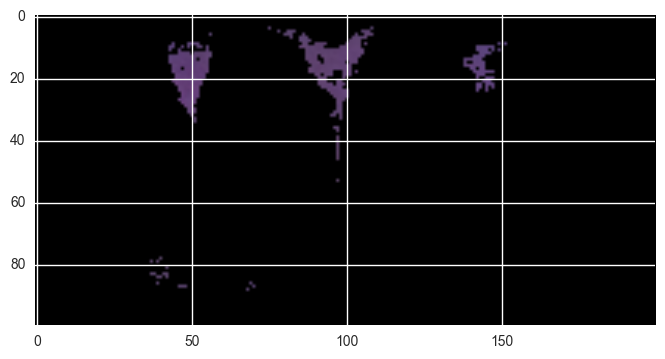

In [29]:
val_1 = [120, 50, 110]
CONST = 20
# output = cvFiltering(image,val_1,CONST)
# plt.imshow(image)
image = cv2.imread('final/002.jpg')
output = cvFiltering(image,val_1,CONST)
plt.imshow(output)

In [69]:
df['Red'] = 0
df['Green'] = 0
df['Blue'] = 0
df['Hue'] = 0.0
df['Lumonisity'] = 0.0
df['Saturation'] = 0.0

In [70]:
avg = (0,0,0)
val = (0,0,0)
counter = 0
imageNum = 1
hls = (0,0,0)
#reading input into dataframe
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type
        im = Image.open('final/'+fn)
        print("running image {}".format(fn))
        width,height = im.size
        dimension = width*height
        pix = im.load()
        totalRGB = (0,0,0)
        totalHLS = (0,0,0)
        for x in range(width):
            for y in range(height):
                pixels = pix[x,y]
                totalRGB = tuple(map(operator.add,pixels,totalRGB))                
                tempHLS = colorsys.rgb_to_hls(pixels[0]/255.0,pixels[1]/255.0,pixels[2]/255.0)
                totalHLS = tuple(map(operator.add,totalHLS,tempHLS))
                
        avgRGB = (totalRGB[0]/dimension,totalRGB[1]/dimension,totalRGB[2]/dimension)
        df['Red'][imageNum-1] = avgRGB[0]
        df['Green'][imageNum-1] = avgRGB[1]
        df['Blue'][imageNum-1] = avgRGB[2] 
        
        
        avgHLS = (totalHLS[0]/float(dimension),totalHLS[1]/float(dimension),totalHLS[2]/float(dimension))
        
        df['Hue'][imageNum-1] = avgHLS[0]
        df['Lumonisity'][imageNum-1] = avgHLS[1]
        df['Saturation'][imageNum-1] = avgHLS[2]
        
        imageNum += 1
        counter += 1

running image 001.jpg
running image 002.jpg
running image 003.jpg
running image 004.jpg
running image 005.jpg
running image 006.jpg
running image 007.jpg
running image 008.jpg
running image 009.jpg
running image 010.jpg
running image 011.jpg
running image 012.jpg
running image 013.jpg
running image 014.jpg
running image 015.jpg
running image 016.jpg
running image 017.jpg
running image 018.jpg
running image 019.jpg
running image 020.jpg
running image 021.jpg
running image 022.jpg
running image 023.jpg
running image 024.jpg
running image 025.jpg
running image 026.jpg
running image 027.jpg
running image 028.jpg
running image 029.jpg
running image 030.jpg
running image 031.jpg
running image 032.jpg
running image 033.jpg
running image 034.jpg
running image 035.jpg
running image 036.jpg
running image 037.jpg
running image 038.jpg
running image 039.jpg
running image 040.jpg
running image 041.jpg
running image 042.jpg
running image 043.jpg
running image 044.jpg
running image 045.jpg
running im

In [73]:
df.to_csv("original.csv",index=False)

In [17]:
dataFrame_ori = pd.read_csv("original.csv")

In [18]:
#df = df.drop('index',1)
df = dataFrame_ori

In [19]:
counter1 = 0
imageNum = 1
# define the list of boundaries
val_1 = [120, 50, 110]
CONST = 20
df['Pink_pix'] = 0


for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type

        image = cv2.imread('final/'+fn)
        
        counter1 += 1
        
        output = cvFiltering(image,val_1,CONST)
            
        pix_val = count_nonblack_np(output)
        df['Pink_pix'][imageNum-1] = pix_val
        imageNum += 1
        




In [ ]:
####EVALUATION GOES HERE######

In [39]:
dataFrame_pink = pd.read_csv("pink.csv")
dataFrame_more = pd.read_csv("more.csv")
dataFrame_all = pd.read_csv("all.csv")
dataFrame_ori = pd.read_csv("original.csv")

In [69]:
splitSeed = 1

In [70]:
X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori=splitData(dataFrame_ori,"score", splitSeed)
X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink=splitData(dataFrame_pink,"score", splitSeed)
X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more=splitData(dataFrame_more,"score", splitSeed)
X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all=splitData(dataFrame_all,"score", splitSeed)

evaluation starting
evaluation starting
evaluation starting
evaluation starting


In [71]:
seed = 1

In [72]:
names_ori, addedFeat_ori, featImp_ori = displayEvaluationNoSplit(X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.64893617021
The C=10 OVR Logistic regression MSE is: 1.45744680851
The default Ordinal Logistic regression MSE is: 1.64893617021
The alpha=0.1 Ordinal Logistic regression MSE is: 1.64893617021
The default Random Forest MSE is: 0.255319148936
The tuned Random Forest MSE is: 0.255319148936
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}


In [73]:
names_pink, addedFeat_pink, featImp_pink = displayEvaluationNoSplit(X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.5
The C=10 OVR Logistic regression MSE is: 1.63829787234
The default Ordinal Logistic regression MSE is: 1.59574468085
The alpha=0.1 Ordinal Logistic regression MSE is: 1.59574468085
The default Random Forest MSE is: 0.287234042553
The tuned Random Forest MSE is: 0.127659574468
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}


In [74]:
names_more, addedFeat_more, featImp_more = displayEvaluationNoSplit(X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.94680851064
The C=100 OVR Logistic regression MSE is: 1.62765957447
The default Ordinal Logistic regression MSE is: 1.5
The alpha=0.1 Ordinal Logistic regression MSE is: 1.5
The default Random Forest MSE is: 1.37234042553
The tuned Random Forest MSE is: 1.20212765957
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}


In [140]:
names_all, addedFeat_all, featImp_all = displayEvaluationNoSplit(X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.36170212766
The C=10 OVR Logistic regression MSE is: 1.3829787234
The default Ordinal Logistic regression MSE is: 1.1914893617
The alpha=0.1 Ordinal Logistic regression MSE is: 1.10638297872
The default Random Forest MSE is: 0.893617021277
The tuned Random Forest MSE is: 1.06382978723
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 9, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}


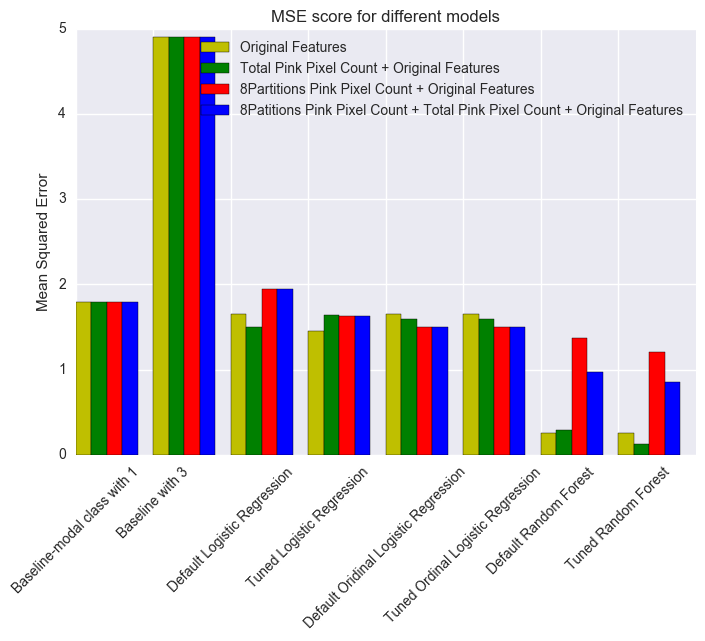

In [76]:
plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)

In [ ]:
###################LEARNING CURVE##################

In [77]:
from sklearn.model_selection import learning_curve

In [78]:
X = dataFrame_pink.drop("score",1)

In [79]:
y = dataFrame_pink["score"]

In [80]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)

In [81]:
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)

In [82]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Negative Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = "neg_mean_squared_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pylab' from '/usr/local/lib/python2.7/site-packages/matplotlib/pylab.pyc'>

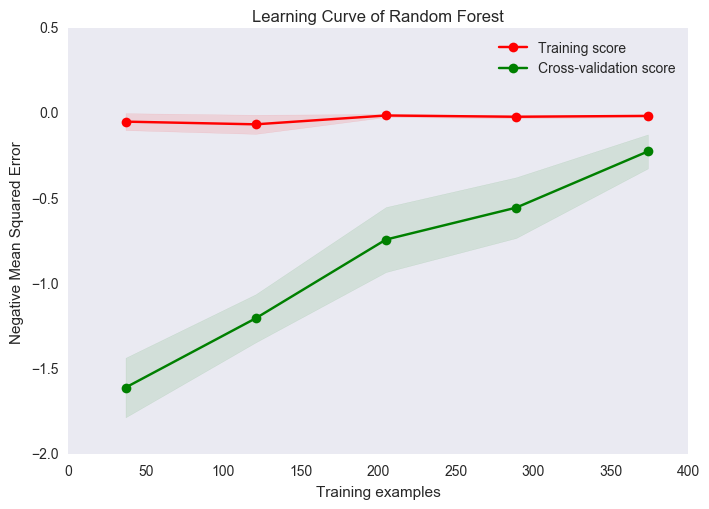

In [83]:
plot_learning_curve(rf_model, "Learning Curve of Random Forest", X, y, ylim=None, cv=sss, n_jobs=-1)

In [ ]:
###########CONFUSION MATRIX############

In [55]:
from sklearn.metrics import confusion_matrix
import itertools

In [56]:
seed=1

In [58]:
parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
rf_conf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
rf_conf_grid = GridSearchCV(rf, parameters, n_jobs=-1, scoring = "neg_mean_squared_error")
rf_conf_grid.fit(X_train_pink, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'min_samples_split': [2, 5], 'max_depth': [None, 50, 100], 'min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
#rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)

In [64]:
y_pred = rf_conf_grid.predict(X_test_pink)

In [65]:
metrics.mean_squared_error(y_test,y_pred)

0.1276595744680851

In [66]:
metrics.accuracy_score(y_test,y_pred)

0.93617021276595747

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[26  4  0  0  0  0]
 [ 0 39  0  0  0  0]
 [ 2  0 11  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  0  4]]


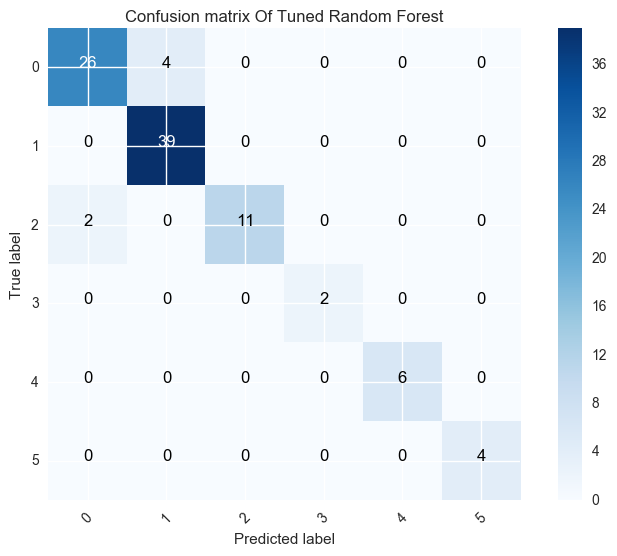

In [68]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5],
                      title='Confusion matrix Of Tuned Random Forest')

In [85]:
#####RUNNING ACCURACY VERSION###########

In [101]:
ACnames_ori, ACaddedFeat_ori, ACfeatImp_ori = displayEvaluationAccuracy(X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.542553191489
The C=0.1 OVR Logistic regression accurracy is: 0.563829787234
The default Ordinal Logistic regression accurracy is: 0.563829787234
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.563829787234
The default Random Forest accurracy is: 0.872340425532
The tuned Random Forest accurracy is: 0.872340425532
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features'

In [102]:
ACnames_pink, ACaddedFeat_pink, ACfeatImp_pink = displayEvaluationAccuracy(X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.585106382979
The C=0.01 OVR Logistic regression accurracy is: 0.563829787234
The default Ordinal Logistic regression accurracy is: 0.531914893617
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.531914893617
The default Random Forest accurracy is: 0.872340425532
The tuned Random Forest accurracy is: 0.936170212766
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features

In [103]:
ACnames_more, ACaddedFeat_more, ACfeatImp_more = displayEvaluationAccuracy(X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.585106382979
The C=0.1 OVR Logistic regression accurracy is: 0.574468085106
The default Ordinal Logistic regression accurracy is: 0.563829787234
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.563829787234
The default Random Forest accurracy is: 0.68085106383
The tuned Random Forest accurracy is: 0.765957446809
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 

In [104]:
ACnames_all, ACaddedFeat_all, ACfeatImp_all = displayEvaluationAccuracy(X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all ,'score', seed)


picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.585106382979
The C=0.1 OVR Logistic regression accurracy is: 0.574468085106
The default Ordinal Logistic regression accurracy is: 0.563829787234
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.563829787234
The default Random Forest accurracy is: 0.744680851064
The tuned Random Forest accurracy is: 0.776595744681
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features':

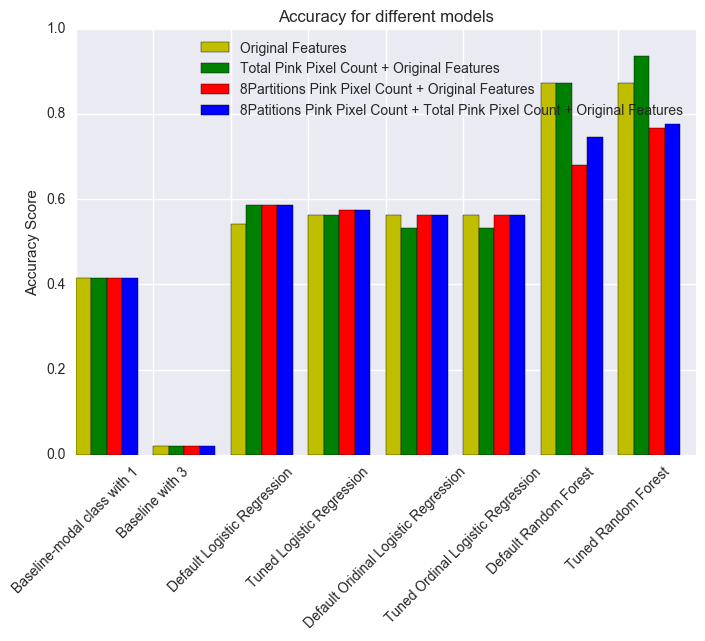

In [105]:
plotBarPlotAllACC(ACnames_ori, ACaddedFeat_ori, ACaddedFeat_pink, ACaddedFeat_more, ACaddedFeat_all)

In [110]:
########EVALUATE MULTIPLE TIMES to get std#######

In [154]:
########LOADING#################
dataFrame_pink = pd.read_csv("pink.csv")
dataFrame_more = pd.read_csv("more.csv")
dataFrame_all = pd.read_csv("all.csv")
dataFrame_ori = pd.read_csv("original.csv")

In [155]:
#######LIST OF DATAS#############
score_ori = []
score_pink = []
score_more = []
score_all = []
feature_ori = []
feature_pink = []
feature_more = []
feature_all = []
name = []

In [156]:
#########LOOPING#############
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori=splitData(dataFrame_ori,"score", splitSeed)
    X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink=splitData(dataFrame_pink,"score", splitSeed)
    X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more=splitData(dataFrame_more,"score", splitSeed)
    X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all=splitData(dataFrame_all,"score", splitSeed)
    seed = i
    names_ori, addedFeat_ori, featImp_ori = displayEvaluationNoSplit(X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori ,'score', seed)
    names_pink, addedFeat_pink, featImp_pink = displayEvaluationNoSplit(X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink ,'score', seed)
    names_more, addedFeat_more, featImp_more = displayEvaluationNoSplit(X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more ,'score', seed)
    names_all, addedFeat_all, featImp_all = displayEvaluationNoSplit(X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all ,'score', seed)
    name = names_ori
    score_ori.append(addedFeat_ori)
    score_pink.append(addedFeat_pink)
    score_more.append(addedFeat_more)
    score_all.append(addedFeat_all)
    feature_ori.append(featImp_ori)
    feature_pink.append(featImp_pink)
    feature_more.append(featImp_more)
    feature_all.append(featImp_all)

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.71276595745
The C=1 OVR Logistic regression MSE is: 1.71276595745
The default Ordinal Logistic regression MSE is: 1.06382978723
The alpha=0.1 Ordinal Logistic regression MSE is: 1.06382978723
The default Random Forest MSE is: 0.457446808511
The tuned Random Forest MSE is: 0.478723404255
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 0,

In [157]:
def plotBarPlotAllErr(Name, Val0, Val1, Val2, Val3, Err0, Err1, Err2, Err3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots()
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features', yerr=Err0)
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features', yerr=Err1)
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features', yerr=Err2)
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features', yerr=Err3)
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Mean Squared Error')
    plt.title('MSE score for different models')
    plt.legend(loc=1)  

In [158]:
ori_val=np.mean(np.asarray(score_ori),axis=0)
pink_val=np.mean(np.asarray(score_pink),axis=0)
more_val=np.mean(np.asarray(score_more),axis=0)
all_val=np.mean(np.asarray(score_all),axis=0)

In [265]:
np.mean(np.asarray(feature_pink),axis=0)

array([ 0.12778363,  0.12238195,  0.15432133,  0.12024312,  0.13109732,
        0.16027493,  0.18389772])

In [270]:
np.mean(np.asarray(feature_all),axis=0)

array([ 0.04128229,  0.0329589 ,  0.03134894,  0.04626564,  0.06004737,
        0.04052723,  0.03543438,  0.05440792,  0.08844482,  0.08845721,
        0.10606092,  0.09311502,  0.08563301,  0.10215215,  0.09386421])

In [266]:
np.mean(np.asarray(feature_more),axis=0)

array([ 0.04864887,  0.03769235,  0.03793895,  0.05502835,  0.06753179,
        0.04832327,  0.04545282,  0.06408153,  0.09786703,  0.08384113,
        0.11640223,  0.09733975,  0.09218947,  0.10766246])

In [159]:
# ori_std = np.std(np.asarray(score_ori),axis=0)
# pink_std = np.std(np.asarray(score_pink),axis=0)
# more_std = np.std(np.asarray(score_more),axis=0)
# all_std = np.std(np.asarray(score_all),axis=0)

In [160]:
import scipy.stats

In [163]:
ori_std = 1.96*scipy.stats.sem(np.asarray(score_ori),axis=0)
pink_std = 1.96*scipy.stats.sem(np.asarray(score_pink),axis=0)
more_std = 1.96*scipy.stats.sem(np.asarray(score_more),axis=0)
all_std = 1.96*scipy.stats.sem(np.asarray(score_all),axis=0)

In [193]:
pink_val

array([ 1.79787234,  4.90425532,  1.45531915,  1.45744681,  1.0606383 ,
        1.0606383 ,  0.32340426,  0.25      ])

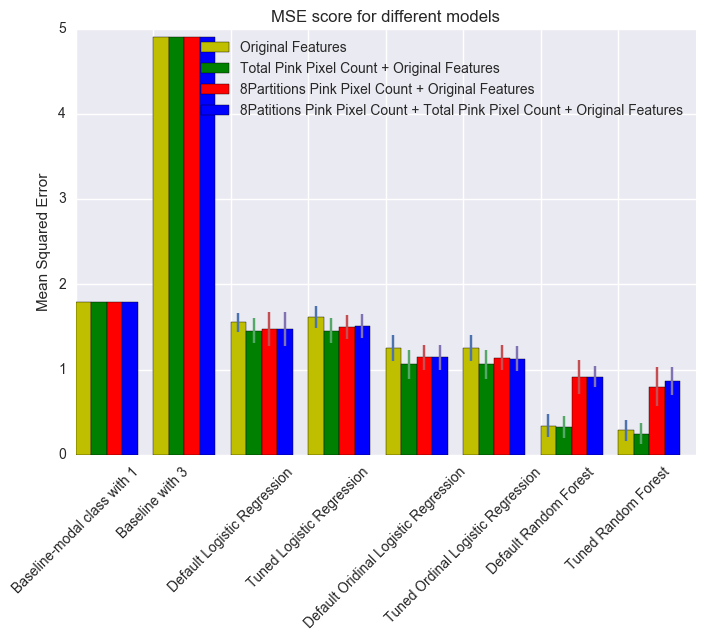

In [164]:
plotBarPlotAllErr(name, ori_val, pink_val, more_val, all_val, ori_std, pink_std, more_std, all_std)

In [175]:
###STORING####
%store score_ori
%store score_pink
%store score_more
%store score_all
%store feature_ori 
%store feature_pink
%store feature_more
%store feature_all
%store name

Stored 'score_ori' (list)
Stored 'score_pink' (list)
Stored 'score_more' (list)
Stored 'score_all' (list)
Stored 'feature_ori' (list)
Stored 'feature_pink' (list)
Stored 'feature_more' (list)
Stored 'feature_all' (list)
Stored 'name' (list)


In [165]:
#########ACCURACY VERSION############

In [167]:
ACscore_ori = []
ACscore_pink = []
ACscore_more = []
ACscore_all = []
ACfeature_ori = []
ACfeature_pink = []
ACfeature_more = []
ACfeature_all = []
ACname = []

In [168]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori=splitData(dataFrame_ori,"score", splitSeed)
    X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink=splitData(dataFrame_pink,"score", splitSeed)
    X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more=splitData(dataFrame_more,"score", splitSeed)
    X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all=splitData(dataFrame_all,"score", splitSeed)
    seed = i
    ACnames_ori, ACaddedFeat_ori, ACfeatImp_ori = displayEvaluationAccuracy(X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori ,'score', seed)
    ACnames_pink, ACaddedFeat_pink, ACfeatImp_pink = displayEvaluationAccuracy(X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink ,'score', seed)
    ACnames_more, ACaddedFeat_more, ACfeatImp_more = displayEvaluationAccuracy(X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more ,'score', seed)
    ACnames_all, ACaddedFeat_all, ACfeatImp_all = displayEvaluationAccuracy(X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all ,'score', seed)
    name = names_ori
    ACscore_ori.append(ACaddedFeat_ori)
    ACscore_pink.append(ACaddedFeat_pink)
    ACscore_more.append(ACaddedFeat_more)
    ACscore_all.append(ACaddedFeat_all)
    ACfeature_ori.append(ACfeatImp_ori)
    ACfeature_pink.append(ACfeatImp_pink)
    ACfeature_more.append(ACfeatImp_more)
    ACfeature_all.append(ACfeatImp_all)

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.531914893617
The C=0.1 OVR Logistic regression accurracy is: 0.510638297872
The default Ordinal Logistic regression accurracy is: 0.531914893617
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.531914893617
The default Random Forest accurracy is: 0.86170212766
The tuned Random Forest accurracy is: 0.904255319149
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fracti

In [327]:
def plotBarPlotAllErrAC(Name, Val0, Val1, Val2, Val3, Err0, Err1, Err2, Err3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots()
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features', yerr=Err0)
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features', yerr=Err1)
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features', yerr=Err2)
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features', yerr=Err3)
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Accuracy')
    plt.title('Accuracy for different models')
    plt.legend(loc=2)  

In [170]:
ACori_val=np.mean(np.asarray(ACscore_ori),axis=0)
ACpink_val=np.mean(np.asarray(ACscore_pink),axis=0)
ACmore_val=np.mean(np.asarray(ACscore_more),axis=0)
ACall_val=np.mean(np.asarray(ACscore_all),axis=0)

In [171]:
ACori_std = 1.96*scipy.stats.sem(np.asarray(ACscore_ori),axis=0)
ACpink_std = 1.96*scipy.stats.sem(np.asarray(ACscore_pink),axis=0)
ACmore_std = 1.96*scipy.stats.sem(np.asarray(ACscore_more),axis=0)
ACall_std = 1.96*scipy.stats.sem(np.asarray(ACscore_all),axis=0)

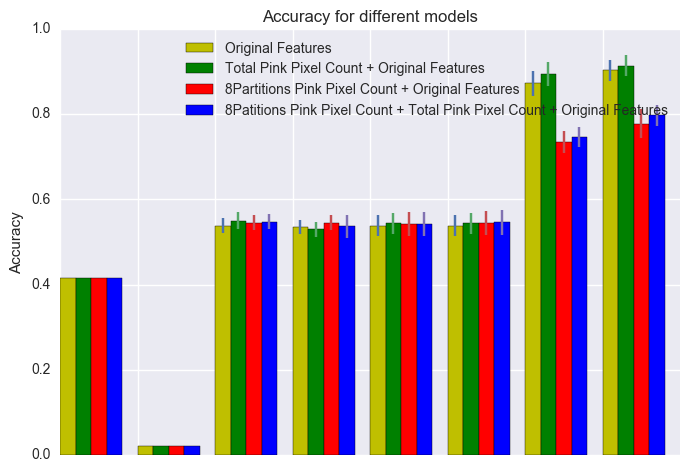

In [172]:
plotBarPlotAllErrAC(ACname, ACori_val, ACpink_val, ACmore_val, ACall_val, ACori_std, ACpink_std, ACmore_std, ACall_std)

In [176]:
#####STORING######
%store ACscore_ori
%store ACscore_pink
%store ACscore_more
%store ACscore_all
%store ACfeature_ori
%store ACfeature_pink
%store ACfeature_more
%store ACfeature_all
%store ACname

Stored 'ACscore_ori' (list)
Stored 'ACscore_pink' (list)
Stored 'ACscore_more' (list)
Stored 'ACscore_all' (list)
Stored 'ACfeature_ori' (list)
Stored 'ACfeature_pink' (list)
Stored 'ACfeature_more' (list)
Stored 'ACfeature_all' (list)
Stored 'ACname' (list)


In [179]:
########SVM#########

In [180]:
svm_parameters = {'C':[0.01,0.1,1,10,100,100,1000]}
svm_model = sklearn.svm.SVC(random_state=seed)
svm_model_grid = GridSearchCV(svm_model, svm_parameters, n_jobs=-1, scoring = "neg_mean_squared_error")
svm_model_grid.fit(X_train_pink, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=9, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [181]:
y_pred = rf_conf_grid.predict(X_test_pink)


In [182]:
metrics.mean_squared_error(y_test,y_pred)

0.021276595744680851

In [183]:
metrics.accuracy_score(y_test,y_pred)

0.97872340425531912

In [185]:
-

In [186]:
EXscore_ori = []
EXscore_pink = []
EXscore_more = []
EXscore_all = []
EXname = []

In [187]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori=splitData(dataFrame_ori,"score", splitSeed)
    X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink=splitData(dataFrame_pink,"score", splitSeed)
    X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more=splitData(dataFrame_more,"score", splitSeed)
    X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all=splitData(dataFrame_all,"score", splitSeed)
    seed = i
    names_ori, addedFeat_ori = displayEvaluationNoSplitSVM(X_train_ori, X_test_ori, y_train, y_test, trainSet_ori, testSet_ori ,'score', seed)
    names_pink, addedFeat_pink = displayEvaluationNoSplitSVM(X_train_pink, X_test_pink, y_train, y_test, trainSet_pink, testSet_pink ,'score', seed)
    names_more, addedFeat_more = displayEvaluationNoSplitSVM(X_train_more, X_test_more, y_train, y_test, trainSet_more, testSet_more ,'score', seed)
    names_all, addedFeat_all = displayEvaluationNoSplitSVM(X_train_all, X_test_all, y_train, y_test, trainSet_all, testSet_all ,'score', seed)
    name = names_ori
    EXscore_ori.append(addedFeat_ori)
    EXscore_pink.append(addedFeat_pink)
    EXscore_more.append(addedFeat_more)
    EXscore_all.append(addedFeat_all)

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.71276595745
The C=1 OVR Logistic regression MSE is: 1.71276595745
The default Ordinal Logistic regression MSE is: 1.06382978723
The alpha=0.1 Ordinal Logistic regression MSE is: 1.06382978723
The default Random Forest MSE is: 0.457446808511
The tuned Random Forest MSE is: 0.478723404255
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criteri

In [188]:
EXori_val=np.mean(np.asarray(EXscore_ori),axis=0)
EXpink_val=np.mean(np.asarray(EXscore_pink),axis=0)
EXmore_val=np.mean(np.asarray(EXscore_more),axis=0)
EXall_val=np.mean(np.asarray(EXscore_all),axis=0)
EXori_std = 1.96*scipy.stats.sem(np.asarray(EXscore_ori),axis=0)
EXpink_std = 1.96*scipy.stats.sem(np.asarray(EXscore_pink),axis=0)
EXmore_std = 1.96*scipy.stats.sem(np.asarray(EXscore_more),axis=0)
EXall_std = 1.96*scipy.stats.sem(np.asarray(EXscore_all),axis=0)

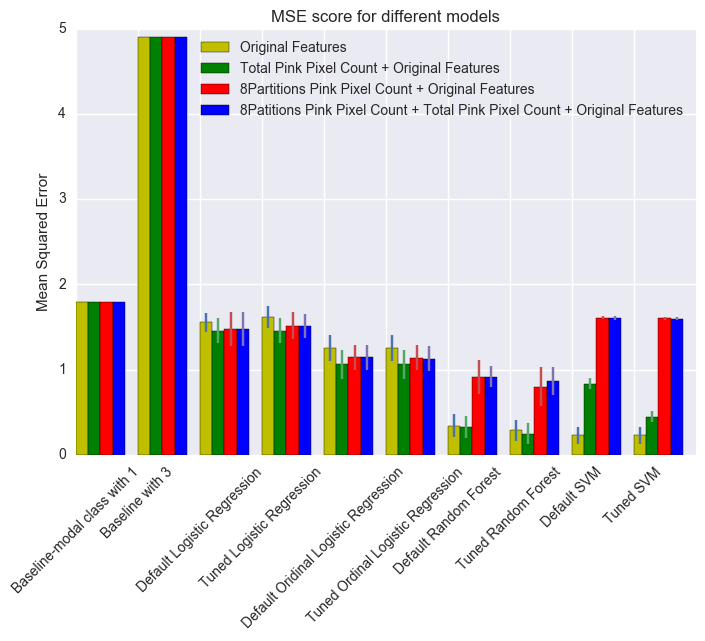

In [189]:
plotBarPlotAllErr(name, EXori_val, EXpink_val, EXmore_val, EXall_val, EXori_std, EXpink_std, EXmore_std, EXall_std)

In [190]:
EXori_val

array([ 1.79787234,  4.90425532,  1.55425532,  1.61489362,  1.25212766,
        1.25212766,  0.34361702,  0.28723404,  0.22765957,  0.22765957])

In [191]:
EXpink_val

array([ 1.79787234,  4.90425532,  1.45531915,  1.45744681,  1.0606383 ,
        1.0606383 ,  0.32340426,  0.25      ,  0.83510638,  0.44893617])

In [195]:
####NORMALIZE DATA##########

In [15]:
dataFrame_more_normalized = pd.read_csv("more.csv")

In [16]:
dataFrame_more_normalized = dataFrame_more_normalized.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [17]:
dataFrame_more_normalized

,score,One,Two,Three,Four,Five,Six,Seven,Eight,Red,Green,Blue,Hue,Lumonisity,Saturation
0,-0.047863,-0.051748,-0.038752,-0.038802,-0.051573,0.121089,-0.008176,0.014239,-0.039464,-0.131952,-0.012021,-0.072674,-0.205796,-0.090137,-0.253304
1,-0.047863,0.147423,0.573317,0.241370,-0.049507,-0.032196,-0.059300,-0.067227,-0.059537,-0.173048,-0.134323,-0.083973,0.335675,-0.137559,-0.315249
2,-0.047863,-0.047598,0.073317,0.071111,-0.026780,0.256126,0.147244,-0.038714,0.048128,-0.118253,-0.148712,-0.106572,0.137588,-0.124692,-0.197438
3,-0.247863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,0.052980,-0.047992,-0.134821,-0.475971,-0.019194,0.023936
4,-0.247863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,0.080377,0.117475,0.000773,-0.398711,0.074477,-0.180526
5,-0.247863,0.041613,0.107800,-0.030182,-0.051573,-0.059568,-0.059300,-0.067227,-0.059537,-0.166198,-0.019215,-0.027476,0.148585,-0.087475,-0.417080
6,-0.047863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,0.265309,0.074310,0.068569,0.153106,0.180428,0.234759
7,-0.047863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,0.306404,0.088698,0.040321,-0.196490,0.189937,0.310042
8,-0.247863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,-0.022363,0.088698,0.017722,-0.258759,0.033110,-0.306956
9,-0.247863,-0.051748,-0.049528,-0.049578,-0.051573,-0.059568,-0.067480,-0.067227,-0.059537,0.169418,0.326108,0.175914,-0.209904,0.228174,-0.282353


In [18]:
dataFrame_more_normalized_dummy = pd.read_csv("more.csv")

In [19]:
dataFrame_more_normalized['score'] = dataFrame_more_normalized_dummy['score']

In [20]:
splitSeed = 2

In [21]:
seed = 2

In [22]:
X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm=splitData(dataFrame_more_normalized,"score", splitSeed)

evaluation starting


In [28]:
names_more_norm, addedFeat_more_norm = displayEvaluationNoSplitSVM(X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm ,'score', seed)

picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned SVM estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.14893617021
The C=1000 OVR Logistic regression MSE is: 0.425531914894
The default Ordinal Logistic regression MSE is: 0.670212765957
The alpha=0.1 Ordinal Logistic regression MSE is: 0.468085106383
The default Random Forest MSE is: 0.276595744681
The tuned Random Forest MSE is: 0.0957446808511
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 2, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_d

ValueError: too many values to unpack

In [295]:
dataFrame_ori_norm = pd.read_csv("original.csv")
dataFrame_pink_norm = pd.read_csv("pink.csv")
dataFrame_more_norm = pd.read_csv("more.csv")
dataFrame_all_norm = pd.read_csv("all.csv")

In [296]:
dataFrame_ori_target = dataFrame_ori_norm[['score']]
dataFrame_pink_target = dataFrame_pink_norm[['score']]
dataFrame_more_target = dataFrame_more_norm[['score']]
dataFrame_all_target = dataFrame_all_norm[['score']]

In [297]:
dataFrame_ori_norm = dataFrame_ori_norm.drop('score',1)
dataFrame_pink_norm = dataFrame_pink_norm.drop('score',1)
dataFrame_more_norm = dataFrame_more_norm.drop('score',1)
dataFrame_all_norm = dataFrame_all_norm.drop('score',1)

In [298]:
dataFrame_ori_norm=dataFrame_ori_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_pink_norm=dataFrame_pink_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_more_norm=dataFrame_more_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_all_norm=dataFrame_all_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [299]:
dataFrame_ori_norm['score'] = dataFrame_ori_target
dataFrame_pink_norm['score'] = dataFrame_pink_target
dataFrame_more_norm['score'] = dataFrame_more_target
dataFrame_all_norm['score'] = dataFrame_all_target

In [305]:
score_ori_norm=[]
score_pink_norm=[]
score_more_norm=[]
score_all_norm=[]
name_norm = []

In [306]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", splitSeed)
    X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)
    X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm=splitData(dataFrame_more_norm,"score", splitSeed)
    X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm=splitData(dataFrame_all_norm,"score", splitSeed)
    seed = i
    names_ori_norm, addedFeat_ori_norm = displayEvaluationNoSplitSVM(X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm ,'score', seed)
    names_pink_norm, addedFeat_pink_norm = displayEvaluationNoSplitSVM(X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm ,'score', seed)
    names_more_norm, addedFeat_more_norm = displayEvaluationNoSplitSVM(X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm ,'score', seed)
    names_all_norm, addedFeat_all_norm = displayEvaluationNoSplitSVM(X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm ,'score', seed)
    score_ori_norm.append(addedFeat_ori_norm)
    score_pink_norm.append(addedFeat_pink_norm)
    score_more_norm.append(addedFeat_more_norm)
    score_all_norm.append(addedFeat_all_norm)
    name_norm = names_ori_norm

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned RF estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.85106382979
The C=1000 OVR Logistic regression MSE is: 1.70212765957
The default Ordinal Logistic regression MSE is: 1.77659574468
The alpha=0.1 Ordinal Logistic regression MSE is: 1.09574468085
The default Random Forest MSE is: 0.457446808511
The tuned Random Forest MSE is: 0.404255319149
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'crite

In [307]:
ori_val_norm=np.mean(np.asarray(score_ori_norm),axis=0)
pink_val_norm=np.mean(np.asarray(score_pink_norm),axis=0)
more_val_norm=np.mean(np.asarray(score_more_norm),axis=0)
all_val_norm=np.mean(np.asarray(score_all_norm),axis=0)
ori_std_norm = 1.96*scipy.stats.sem(np.asarray(score_ori_norm),axis=0)
pink_std_norm = 1.96*scipy.stats.sem(np.asarray(score_pink_norm),axis=0)
more_std_norm = 1.96*scipy.stats.sem(np.asarray(score_more_norm),axis=0)
all_std_norm = 1.96*scipy.stats.sem(np.asarray(score_all_norm),axis=0)

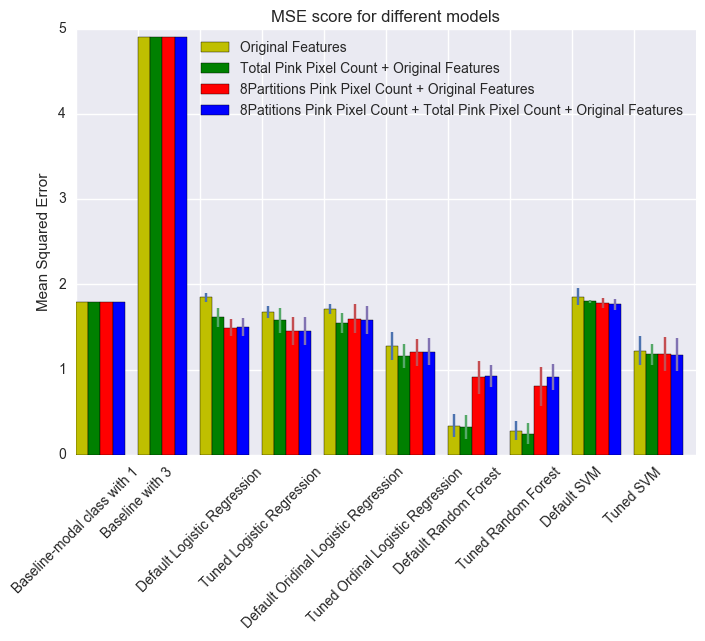

In [309]:
plotBarPlotAllErr(name_norm, ori_val_norm, pink_val_norm, more_val_norm, all_val_norm, ori_std_norm, pink_std_norm, more_std_norm, all_std_norm)

In [311]:
######ACCURACY VERSION#########

array([ 1.79787234,  4.90425532,  1.61382979,  1.57765957,  1.54468085,
        1.16382979,  0.32765957,  0.25      ,  1.8       ,  1.17765957])

In [317]:
def displayEvaluationAccuracy(X_train, X_test, y_train, y_test, trainSet, testSet ,label, seed):
    #random state for RF set to 0
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    #rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1,random_state=seed)
    #rfTuned.fit(X_train, y_train)
    parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
    rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
    rf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    
    
    print("SVM estimate")
    svmDefault = sklearn.svm.SVC(random_state=seed)
    svmDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    svm_parameters = {'C':[0.01,0.1,1,10,100,100,1000]}
    svm_model = sklearn.svm.SVC(random_state=seed)
    svm_model_grid = GridSearchCV(svm_model, svm_parameters, n_jobs=-1)
    svm_model_grid.fit(X_train, y_train)
    
    
    
    print("evaluating MSEVal")
    Model = ["Baseline-modal class with 1", "Baseline with 3", "Default Logistic Regression", "Tuned Logistic Regression", "Default Oridinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest", "Default SVM", "Tuned SVM", "Default SVM", "Tuned SVM"]
    MSEVal = [metrics.accuracy_score(modal1, y_test),metrics.accuracy_score(modal2, y_test), getACC(lrDefault, X_test, y_test), getACC(lr1sde, X_test, y_test), getACC(lritDefault, X_test, y_test), getACC(lrit1sde, X_test, y_test), getACC(rfDefault, X_test, y_test), getACC(rf_grid.best_estimator_, X_test, y_test), getACC(svmDefault, X_test, y_test),  getACC(svm_model_grid.best_estimator_, X_test, y_test)  ]
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model accuracy is: {}".format(MSEVal[0]))
    print("The baseline model accuracy is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression accurracy is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression accurracy is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression accurracy is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression accurracy is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest accurracy is: {}".format(MSEVal[6]))
    print("The tuned Random Forest accurracy is: {}".format(MSEVal[7]))
    print("The tuned parameters for Random Forest")
    print(rf_grid.best_estimator_.get_params())
    print("The default SVM MSE is: {}".format(MSEVal[8]))
    print("The tuned SVM MSE is: {}".format(MSEVal[9]))
    
    
    return Model, MSEVal

In [318]:
ACscore_ori_norm=[]
ACscore_pink_norm=[]
ACscore_more_norm=[]
ACscore_all_norm=[]
ACname_norm = []

In [319]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", splitSeed)
    X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)
    X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm=splitData(dataFrame_more_norm,"score", splitSeed)
    X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm=splitData(dataFrame_all_norm,"score", splitSeed)
    seed = i
    ACnames_ori_norm, ACaddedFeat_ori_norm = displayEvaluationAccuracy(X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm ,'score', seed)
    ACnames_pink_norm, ACaddedFeat_pink_norm = displayEvaluationAccuracy(X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm ,'score', seed)
    ACnames_more_norm, ACaddedFeat_more_norm = displayEvaluationAccuracy(X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm ,'score', seed)
    ACnames_all_norm, ACaddedFeat_all_norm = displayEvaluationAccuracy(X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm ,'score', seed)
    ACscore_ori_norm.append(ACaddedFeat_ori_norm)
    ACscore_pink_norm.append(ACaddedFeat_pink_norm)
    ACscore_more_norm.append(ACaddedFeat_more_norm)
    ACscore_all_norm.append(ACaddedFeat_all_norm)
    ACname_norm = ACnames_ori_norm

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned RF estimate
evaluating MSEVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.478723404255
The C=1000 OVR Logistic regression accurracy is: 0.542553191489
The default Ordinal Logistic regression accurracy is: 0.468085106383
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.531914893617
The default Random Forest accurracy is: 0.86170212766
The tuned Random Forest accurracy is: 0.904255319149
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_sampl

In [320]:
ACori_val_norm=np.mean(np.asarray(ACscore_ori_norm),axis=0)
ACpink_val_norm=np.mean(np.asarray(ACscore_pink_norm),axis=0)
ACmore_val_norm=np.mean(np.asarray(ACscore_more_norm),axis=0)
ACall_val_norm=np.mean(np.asarray(ACscore_all_norm),axis=0)
ACori_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_ori_norm),axis=0)
ACpink_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_pink_norm),axis=0)
ACmore_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_more_norm),axis=0)
ACall_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_all_norm),axis=0)

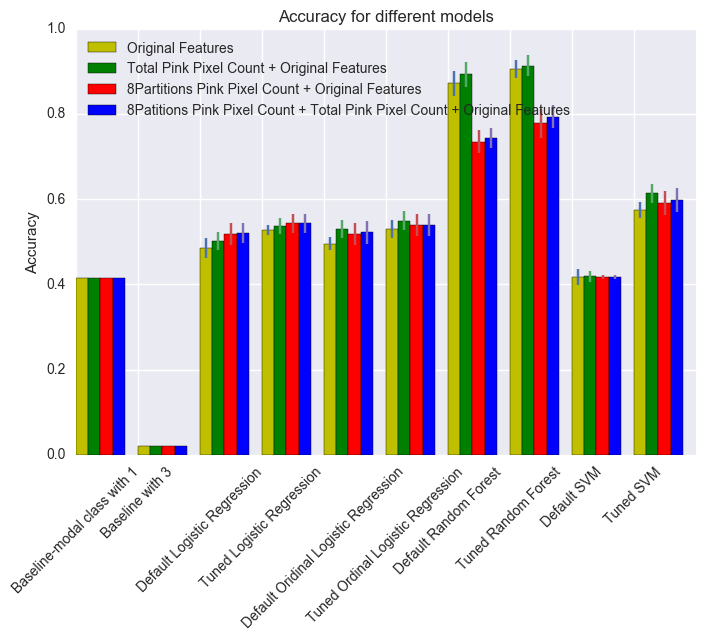

In [328]:
plotBarPlotAllErrAC(ACname_norm, ACori_val_norm, ACpink_val_norm, ACmore_val_norm, ACall_val_norm, ACori_std_norm, ACpink_std_norm, ACmore_std_norm, ACall_std_norm)

In [322]:
############CONFUSION MATRIX NEW#############

In [329]:
from sklearn.metrics import confusion_matrix
import itertools


In [330]:
seed=1
splitSeed = 1

In [331]:
X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)

evaluation starting


In [332]:
parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}

In [333]:
rf_conf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
rf_conf_grid = GridSearchCV(rf, parameters, n_jobs=-1, scoring = "neg_mean_squared_error")

In [334]:
rf_conf_grid.fit(X_train_pink_norm, y_train)
y_pred = rf_conf_grid.predict(X_test_pink_norm)

Confusion matrix, without normalization
[[26  4  0  0  0  0]
 [ 0 39  0  0  0  0]
 [ 2  0 11  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  0  4]]


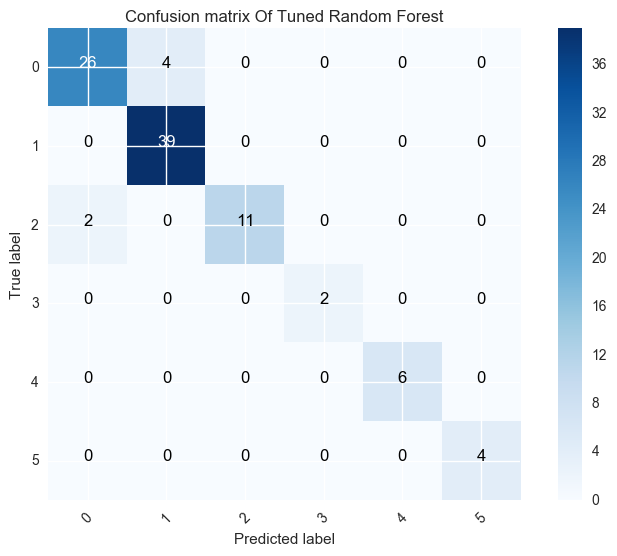

In [335]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5],
                      title='Confusion matrix Of Tuned Random Forest')

In [ ]:
########LEARNING CURVE###########

In [336]:
seed=1

<module 'matplotlib.pylab' from '/usr/local/lib/python2.7/site-packages/matplotlib/pylab.pyc'>

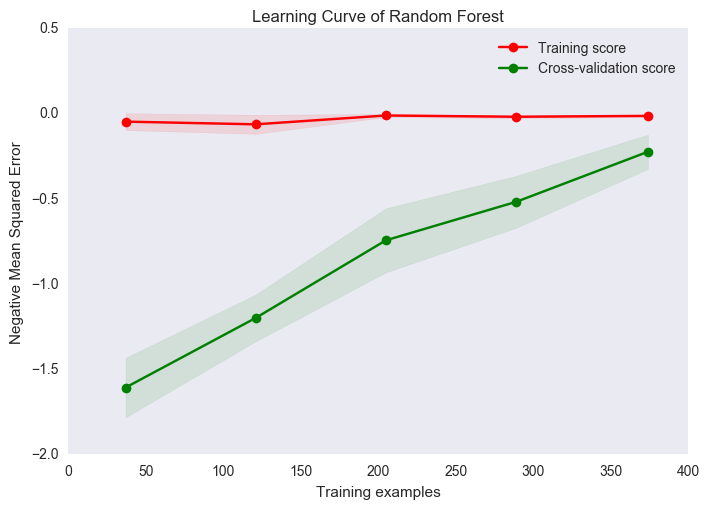

In [337]:
X = dataFrame_pink_norm.drop("score",1)
y = dataFrame_pink_norm["score"]
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
plot_learning_curve(rf_model, "Learning Curve of Random Forest", X, y, ylim=None, cv=sss, n_jobs=-1)

In [ ]:
#########DISTRIBUTION############

In [338]:
import matplotlib.pyplot as plt

In [339]:
import seaborn as sns

In [340]:
sns.set(color_codes=True)

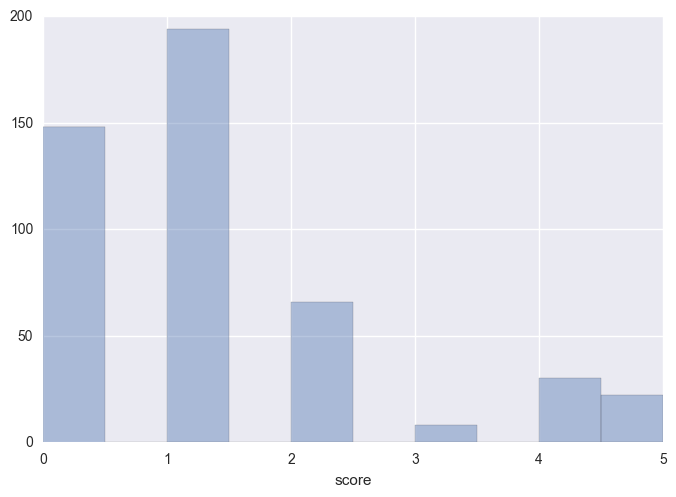

In [343]:
sns.distplot(y,kde=False)

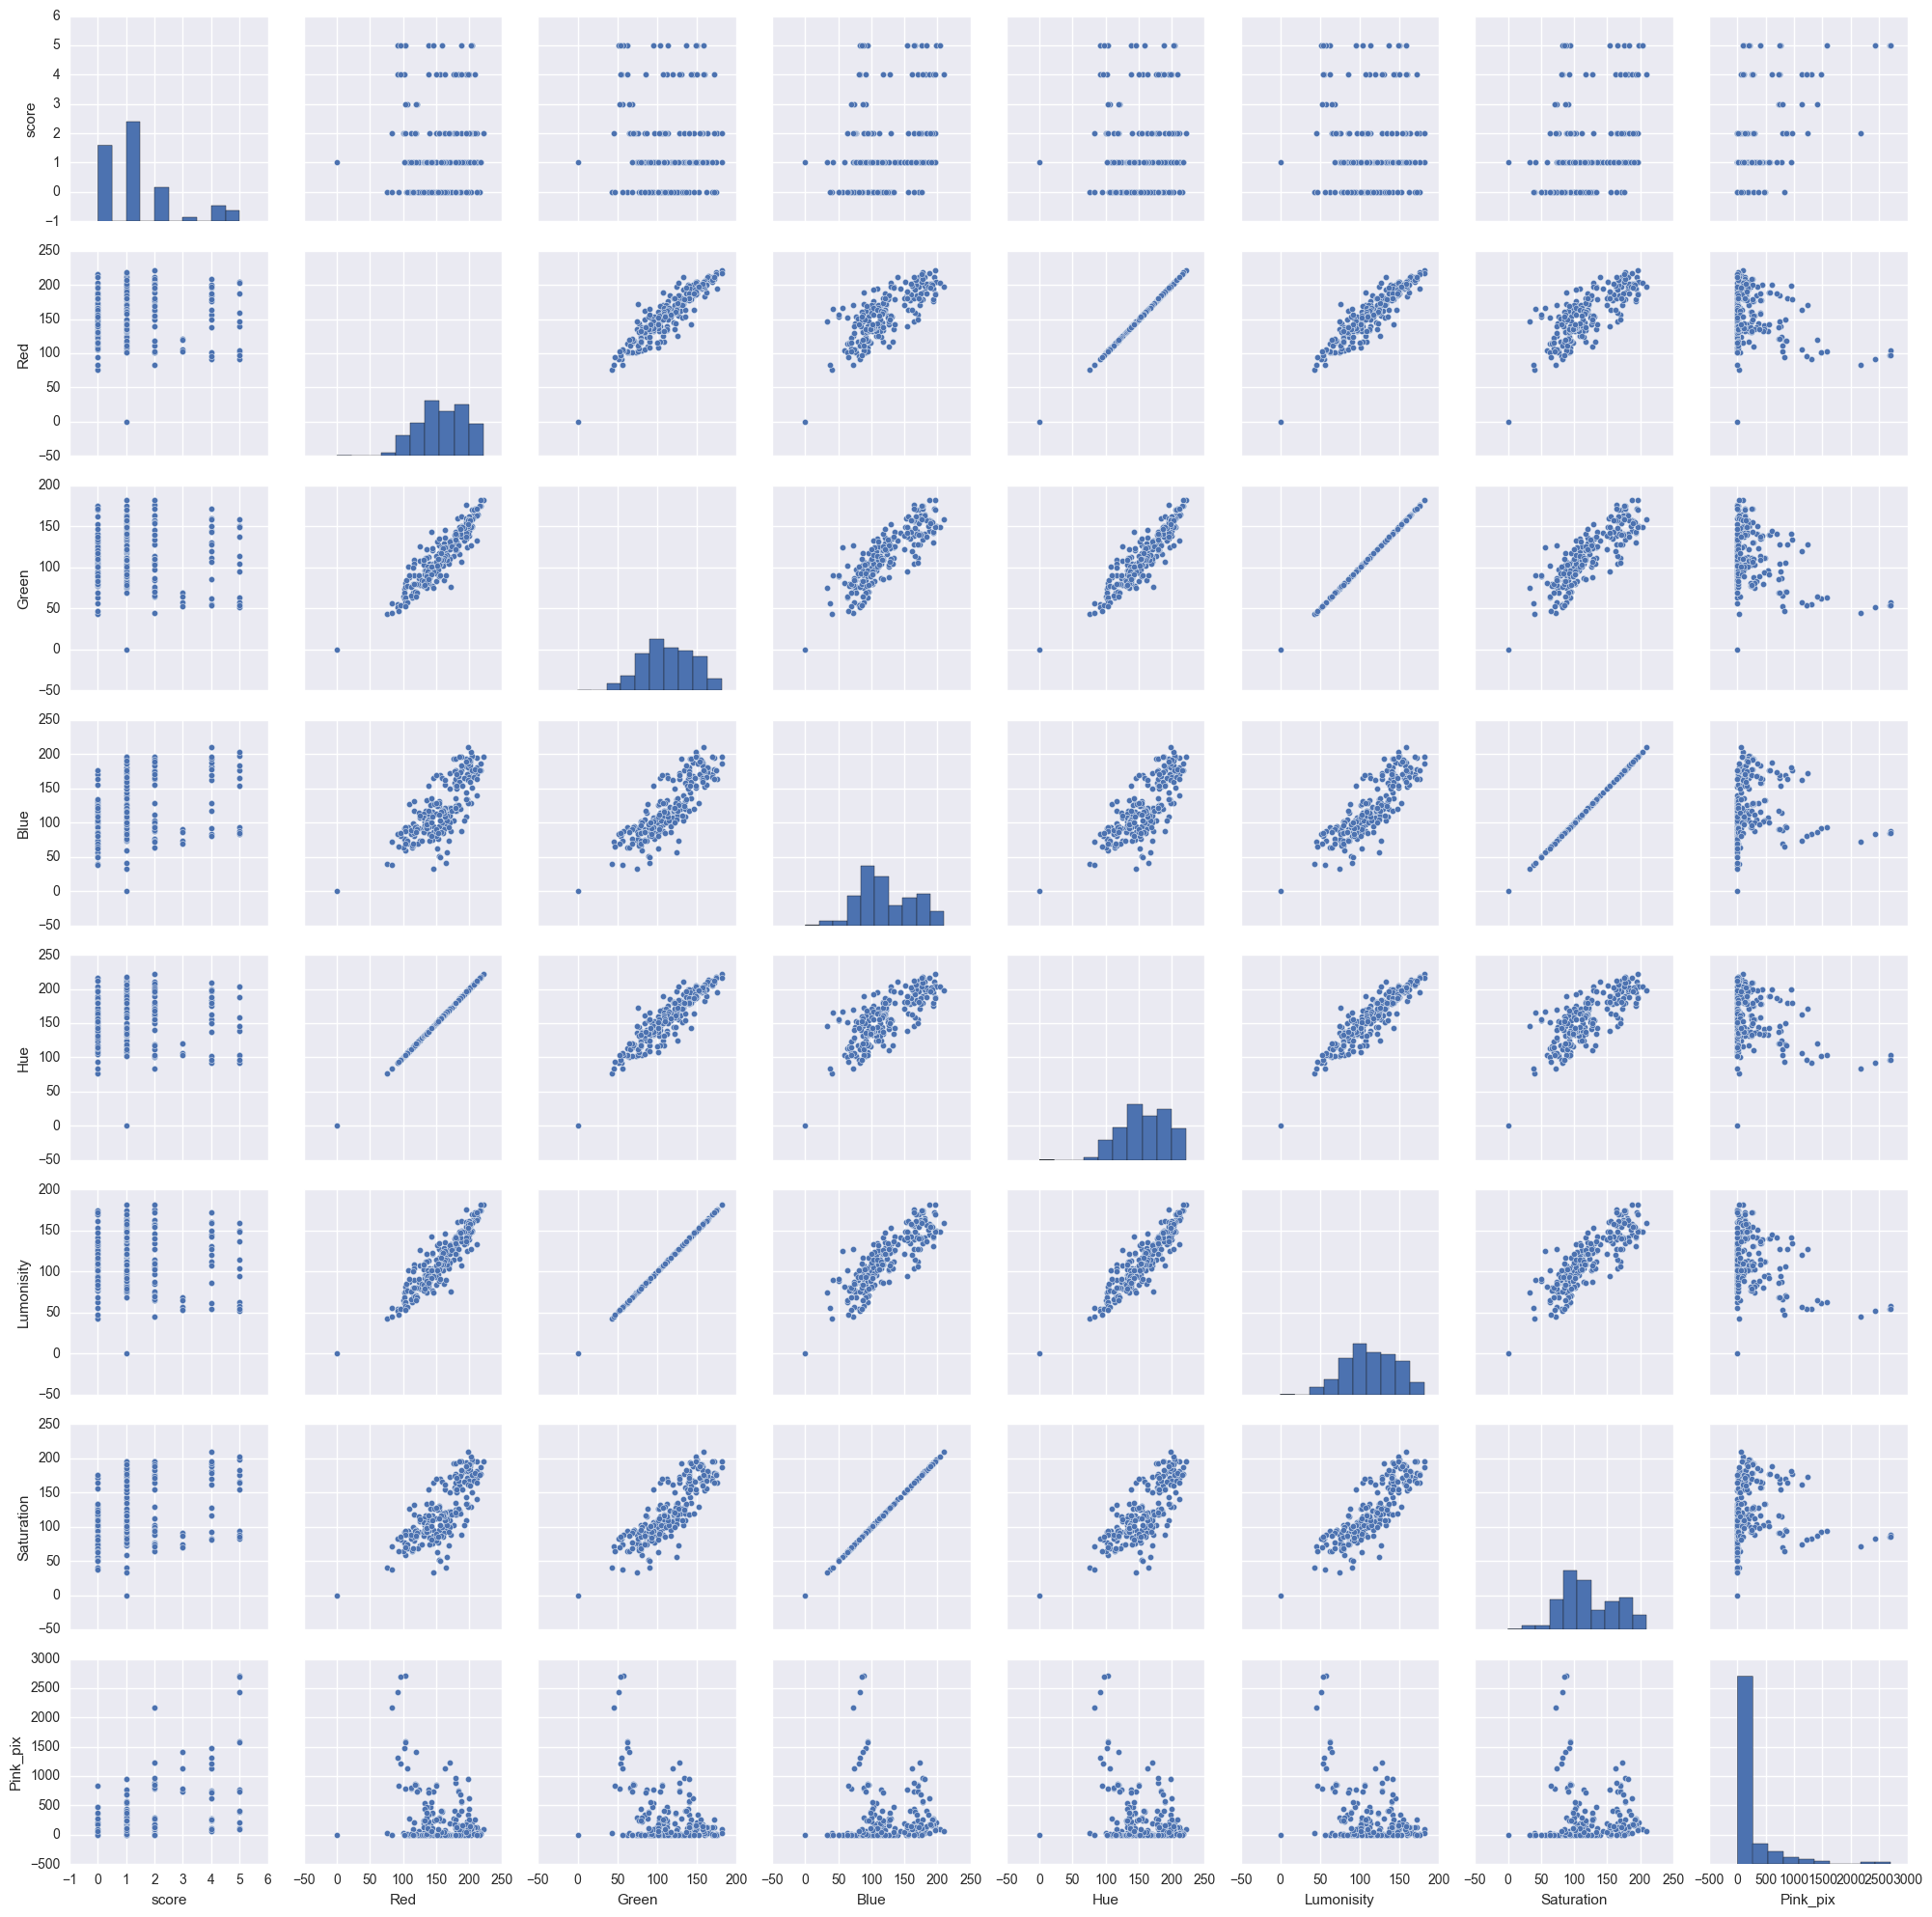

In [346]:
sns.pairplot(dataFrame_pink)

In [347]:
dataFrame_pink

,score,Red,Green,Blue,Hue,Lumonisity,Saturation,Pink_pix
0,1,0,0,0,0,0,0,0
1,1,139,113,109,139,113,109,189
2,1,133,96,107,133,96,107,540
3,0,141,94,103,141,94,103,478
4,0,166,108,98,166,108,98,0
5,0,170,131,122,170,131,122,0
6,1,134,112,117,134,112,117,131
7,1,197,125,134,197,125,134,0
8,0,203,127,129,203,127,129,0
9,0,155,127,125,155,127,125,0


In [24]:
############# EVERYTHING HERE NEW###########

In [46]:
#To predict score
#assumes model already fitted
def getMSE(model, X, y):
    return metrics.mean_squared_error(model.predict(X),y)
#selecting hyperparameter for Logistic Regression using Cross Validation

def findMSE(y_pred,y_actual):
    return metrics.mean_squared_error(y_pred,y_actual)

def xValLR(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            lr = LogisticRegression(C=c, n_jobs=-1)
            lr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getMSE(lr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

#selecting hyperparameter for Ordinal Logistic Regression using Cross Validation
def xValOLR(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            olr = mord.LogisticIT(alpha=c)
            olr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getMSE(olr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

In [47]:
def displayEvaluationNoSplitSVM(X_train, X_test, y_train, y_test, trainSet, testSet ,label, seed):
    #random state for RF set to 0
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLR(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].min()
    best_1sde = best + res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']<=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    #rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1,random_state=seed)
    #rfTuned.fit(X_train, y_train)
    parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
    rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
    rf_grid = GridSearchCV(rf, parameters, n_jobs=-1, scoring = "neg_mean_squared_error")
    rf_grid.fit(X_train, y_train)
    
    print("SVM estimate")
    svmDefault = sklearn.svm.SVC(random_state=seed)
    svmDefault.fit(X_train, y_train)
    
    print("tuned SVM estimate")
    svm_parameters = {'C':[0.01,0.1,1,10,100,100,1000]}
    svm_model = sklearn.svm.SVC(random_state=seed)
    svm_model_grid = GridSearchCV(svm_model, svm_parameters,scoring = "neg_mean_squared_error", n_jobs=-1)
    svm_model_grid.fit(X_train, y_train)
    
    print("evaluating MSEVal")
    Model = ["Baseline-modal class with 1", "Baseline-middle class with 3", "Default OVR Logistic Regression", "Tuned OVR Logistic Regression", "Default Ordinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest", "Default SVM", "Tuned SVM", "Default SVM", "Tuned SVM"]
    MSEVal = [metrics.mean_squared_error(modal1, y_test),metrics.mean_squared_error(modal2, y_test), getMSE(lrDefault, X_test, y_test), getMSE(lr1sde, X_test, y_test), getMSE(lritDefault, X_test, y_test), getMSE(lrit1sde, X_test, y_test), getMSE(rfDefault, X_test, y_test), getMSE(rf_grid.best_estimator_, X_test, y_test), getMSE(svmDefault, X_test, y_test), getMSE(svm_model_grid.best_estimator_, X_test, y_test) ]
    
    
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model MSE is: {}".format(MSEVal[0]))
    print("The baseline model MSE is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression MSE is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression MSE is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression MSE is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression MSE is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest MSE is: {}".format(MSEVal[6]))
    print("The tuned Random Forest MSE is: {}".format(MSEVal[7]))
    print("The tuned parameters for Random Forest")
    print(rf_grid.best_estimator_.get_params())
    print("The default SVM MSE is: {}".format(MSEVal[8]))
    print("The tuned SVM MSE is: {}".format(MSEVal[9]))
    
    
    return Model, MSEVal, rfDefault.feature_importances_

In [48]:
dataFrame_ori_norm = pd.read_csv("original.csv")
dataFrame_pink_norm = pd.read_csv("pink.csv")
dataFrame_more_norm = pd.read_csv("more.csv")
dataFrame_all_norm = pd.read_csv("all.csv")

In [49]:
dataFrame_ori_target = dataFrame_ori_norm[['score']]
dataFrame_pink_target = dataFrame_pink_norm[['score']]
dataFrame_more_target = dataFrame_more_norm[['score']]
dataFrame_all_target = dataFrame_all_norm[['score']]

In [50]:
dataFrame_ori_norm = dataFrame_ori_norm.drop('score',1)
dataFrame_pink_norm = dataFrame_pink_norm.drop('score',1)
dataFrame_more_norm = dataFrame_more_norm.drop('score',1)
dataFrame_all_norm = dataFrame_all_norm.drop('score',1)

In [51]:
dataFrame_ori_norm=dataFrame_ori_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_pink_norm=dataFrame_pink_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_more_norm=dataFrame_more_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_all_norm=dataFrame_all_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [52]:
dataFrame_ori_norm['score'] = dataFrame_ori_target
dataFrame_pink_norm['score'] = dataFrame_pink_target
dataFrame_more_norm['score'] = dataFrame_more_target
dataFrame_all_norm['score'] = dataFrame_all_target

In [53]:
score_ori_norm=[]
score_pink_norm=[]
score_more_norm=[]
score_all_norm=[]
feat_ori_norm=[]
feat_pink_norm=[]
feat_more_norm=[]
feat_all_norm=[]
name_norm = []

In [54]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", splitSeed)
    X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)
    X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm=splitData(dataFrame_more_norm,"score", splitSeed)
    X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm=splitData(dataFrame_all_norm,"score", splitSeed)
    seed = i
    names_ori_norm, addedFeat_ori_norm, feat_ori = displayEvaluationNoSplitSVM(X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm ,'score', seed)
    names_pink_norm, addedFeat_pink_norm, feat_pink = displayEvaluationNoSplitSVM(X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm ,'score', seed)
    names_more_norm, addedFeat_more_norm, feat_more = displayEvaluationNoSplitSVM(X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm ,'score', seed)
    names_all_norm, addedFeat_all_norm, feat_all = displayEvaluationNoSplitSVM(X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm ,'score', seed)
    score_ori_norm.append(addedFeat_ori_norm)
    score_pink_norm.append(addedFeat_pink_norm)
    score_more_norm.append(addedFeat_more_norm)
    score_all_norm.append(addedFeat_all_norm)
    feat_ori_norm.append(feat_ori)
    feat_pink_norm.append(feat_pink)
    feat_more_norm.append(feat_more)
    feat_all_norm.append(feat_all)
    name_norm = names_ori_norm

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned SVM estimate
evaluating MSEVal
The modal class model MSE is: 1.79787234043
The baseline model MSE is: 4.90425531915
The default OVR Logistic regression MSE is: 1.70212765957
The C=10000000 OVR Logistic regression MSE is: 0.36170212766
The default Ordinal Logistic regression MSE is: 0.914893617021
The alpha=0.1 Ordinal Logistic regression MSE is: 0.595744680851
The default Random Forest MSE is: 0.202127659574
The tuned Random Forest MSE is: 0.063829787234
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,

In [55]:
import scipy.stats

In [56]:
ori_val_norm=np.mean(np.asarray(score_ori_norm),axis=0)
pink_val_norm=np.mean(np.asarray(score_pink_norm),axis=0)
more_val_norm=np.mean(np.asarray(score_more_norm),axis=0)
all_val_norm=np.mean(np.asarray(score_all_norm),axis=0)
ori_std_norm = 1.96*scipy.stats.sem(np.asarray(score_ori_norm),axis=0)
pink_std_norm = 1.96*scipy.stats.sem(np.asarray(score_pink_norm),axis=0)
more_std_norm = 1.96*scipy.stats.sem(np.asarray(score_more_norm),axis=0)
all_std_norm = 1.96*scipy.stats.sem(np.asarray(score_all_norm),axis=0)

In [96]:
def plotBarPlotAllErr(Name, Val0, Val1, Val2, Val3, Err0, Err1, Err2, Err3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots(figsize=(10,6))
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features', yerr=Err0)
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features', yerr=Err1)
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features', yerr=Err2)
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features', yerr=Err3)
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Mean Squared Error')
    plt.title('MSE score for different models')
    plt.legend(loc=1)  

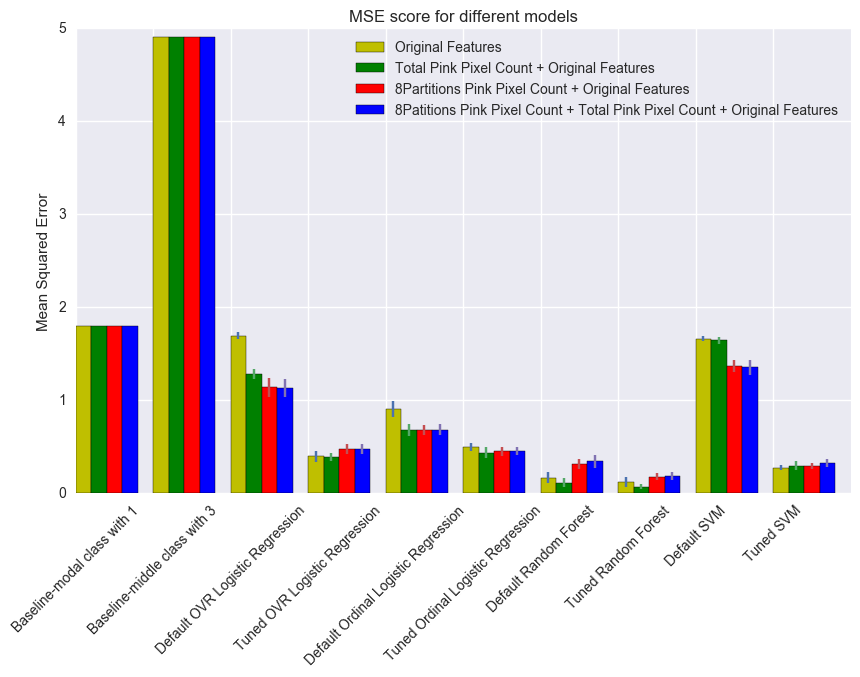

In [97]:
plotBarPlotAllErr(name_norm, ori_val_norm, pink_val_norm, more_val_norm, all_val_norm, ori_std_norm, pink_std_norm, more_std_norm, all_std_norm)

In [98]:
pink_val_norm

array([ 1.79787234,  4.90425532,  1.28085106,  0.38723404,  0.68085106,
        0.43404255,  0.11276596,  0.06702128,  1.64042553,  0.29361702])

In [60]:
def getACC(model, X, y):
    return metrics.accuracy_score(model.predict(X),y)
#selecting hyperparameter for Logistic Regression using Cross Validation

def findACC(y_pred,y_actual):
    return metrics.accuracy_score(y_pred,y_actual)

def xValLRACC(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            lr = LogisticRegression(C=c, n_jobs=-1)
            lr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getACC(lr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

#selecting hyperparameter for Ordinal Logistic Regression using Cross Validation
def xValOLRACC(dataset, label_name, k, cs):
    cv = KFold(n_splits=k)
    scores={}
    for train_index, test_index in cv.split(dataset):
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs:
            olr = mord.LogisticIT(alpha=c)
            olr.fit(tr_f.drop(label_name, 1),tr_f[label_name])
            met = getACC(olr,tr_f.drop(label_name, 1),tr_f[label_name])
            if (scores.has_key(c)):
                scores[c].append(met)
            else:
                scores[c] = [met]
    return scores

def displayEvaluationAccuracy(X_train, X_test, y_train, y_test, trainSet, testSet ,label, seed):
    #random state for RF set to 0
    #cross validation to find best hyperparameter for logistic regression OVR
    rangeVal = range(-8,8)
    cs = [10**i for i in rangeVal]
    print("picking C for LR")
    scores=xValLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    c_1sde = 10**e_1sde
    #print("the following C gives the best scoring: {}, going by 1 standard error rule".format(c_1sde))
    print("done picking C for LR")
    #cross validation to find best hyperparameter for ordinal logistic regression
    rangeVal = range(-1,10)
    cs = [10**i for i in rangeVal]
    print("picking C for OLR")
    scores = xValOLRACC(trainSet,'score', 10,cs)
    xval_dict = {'e':[], 'mu':[], 'sig':[]}
    for i in rangeVal:
        xval_dict['e'].append(i)
        xval_dict['mu'].append(np.array(scores[10**i]).mean())
        xval_dict['sig'].append(np.sqrt(np.array(scores[10**i]).var(ddof=1)))
    res = pd.DataFrame(xval_dict)
    best = res['mu'].max()
    best_1sde = best - res['sig'][(res['mu']==best)]/np.sqrt(len(cs))
    res['low'] = res['mu'] - res['sig']/np.sqrt(len(cs))
    res['up'] = res['mu'] + res['sig']/np.sqrt(len(cs))
    e_max = res['e'][(res['mu']==best)].values[0]
    e_1sde = res['e'][(res['mu']>=best_1sde.values[0])].values.min()
    alpha_1sde = 10**e_1sde
    #print("the following alpha gives the best scoring: {}, going by 1 standard error rule".format(alpha_1sde))
    print("done picking C for OLR")
    #BaseLine ModalClass
    modal1 = np.full((y_test.shape[0],),1)
    modal2 = np.full((y_test.shape[0],),3)
    
    print("LR estimate")
    #Default Logistic Regression
    lrDefault = LogisticRegression(n_jobs=-1)
    lrDefault.fit(X_train, y_train)
    #One Versus Rest Logistic Regression
    print("tuned LR estimate")
    lr1sde = LogisticRegression(C=c_1sde,n_jobs=-1)
    lr1sde.fit(X_train, y_train)
    
    print("OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lritDefault=mord.LogisticIT()
    lritDefault.fit(X_train, y_train)
    
    print("tuned OLR estimate")
    #threshold based ordinal logistic regression
    #immediate threshold variant?
    lrit1sde=mord.LogisticIT(alpha=alpha_1sde)
    lrit1sde.fit(X_train, y_train)
    
    print("RF estimate")
    #random forest 
    rfDefault = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
    rfDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    #rfTuned = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1,random_state=seed)
    #rfTuned.fit(X_train, y_train)
    parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}
    rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
    rf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    
    
    print("SVM estimate")
    svmDefault = sklearn.svm.SVC(random_state=seed)
    svmDefault.fit(X_train, y_train)
    
    print("tuned RF estimate")
    svm_parameters = {'C':[0.01,0.1,1,10,100,100,1000]}
    svm_model = sklearn.svm.SVC(random_state=seed)
    svm_model_grid = GridSearchCV(svm_model, svm_parameters, n_jobs=-1)
    svm_model_grid.fit(X_train, y_train)
    
    
    
    print("evaluating ACCVal")
    Model = ["Baseline-modal class with 1", "Baseline-middle class with 3", "Default Logistic Regression", "Tuned Logistic Regression", "Default Ordinal Logistic Regression", "Tuned Ordinal Logistic Regression", "Default Random Forest", "Tuned Random Forest", "Default SVM", "Tuned SVM", "Default SVM", "Tuned SVM"]
    MSEVal = [metrics.accuracy_score(modal1, y_test),metrics.accuracy_score(modal2, y_test), getACC(lrDefault, X_test, y_test), getACC(lr1sde, X_test, y_test), getACC(lritDefault, X_test, y_test), getACC(lrit1sde, X_test, y_test), getACC(rfDefault, X_test, y_test), getACC(rf_grid.best_estimator_, X_test, y_test), getACC(svmDefault, X_test, y_test),  getACC(svm_model_grid.best_estimator_, X_test, y_test)  ]
    
    #for i in range(len(rfDefault.feature_importances_)):
        #print("the importance of {} is {}".format(X_train.columns[i],rfDefault.feature_importances_[i]))
    
    print("The modal class model accuracy is: {}".format(MSEVal[0]))
    print("The baseline model accuracy is: {}".format(MSEVal[1]))
    print("The default OVR Logistic regression accurracy is: {}".format(MSEVal[2]))
    print("The C={} OVR Logistic regression accurracy is: {}".format(c_1sde, MSEVal[3]))
    print("The default Ordinal Logistic regression accurracy is: {}".format(MSEVal[4]))
    print("The alpha={} Ordinal Logistic regression accurracy is: {}".format(alpha_1sde, MSEVal[5]))
    print("The default Random Forest accurracy is: {}".format(MSEVal[6]))
    print("The tuned Random Forest accurracy is: {}".format(MSEVal[7]))
    print("The tuned parameters for Random Forest")
    print(rf_grid.best_estimator_.get_params())
    print("The default SVM MSE is: {}".format(MSEVal[8]))
    print("The tuned SVM MSE is: {}".format(MSEVal[9]))
    
    
    return Model, MSEVal, rfDefault.feature_importances_

In [61]:
ACscore_ori_norm=[]
ACscore_pink_norm=[]
ACscore_more_norm=[]
ACscore_all_norm=[]
ACfeat_ori_norm=[]
ACfeat_pink_norm=[]
ACfeat_more_norm=[]
ACfeat_all_norm=[]
ACname_norm = []

In [62]:
for i in range(0,10):
    print("EVALUATING CYCLE:{}".format(i))
    splitSeed = i
    X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", splitSeed)
    X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)
    X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm=splitData(dataFrame_more_norm,"score", splitSeed)
    X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm=splitData(dataFrame_all_norm,"score", splitSeed)
    seed = i
    ACnames_ori_norm, ACaddedFeat_ori_norm, ACfeat_ori = displayEvaluationAccuracy(X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm ,'score', seed)
    ACnames_pink_norm, ACaddedFeat_pink_norm, ACfeat_pink = displayEvaluationAccuracy(X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm ,'score', seed)
    ACnames_more_norm, ACaddedFeat_more_norm, ACfeat_more = displayEvaluationAccuracy(X_train_more_norm, X_test_more_norm, y_train, y_test, trainSet_more_norm, testSet_more_norm ,'score', seed)
    ACnames_all_norm, ACaddedFeat_all_norm, ACfeat_all = displayEvaluationAccuracy(X_train_all_norm, X_test_all_norm, y_train, y_test, trainSet_all_norm, testSet_all_norm ,'score', seed)
    ACscore_ori_norm.append(ACaddedFeat_ori_norm)
    ACscore_pink_norm.append(ACaddedFeat_pink_norm)
    ACscore_more_norm.append(ACaddedFeat_more_norm)
    ACscore_all_norm.append(ACaddedFeat_all_norm)
    ACfeat_ori_norm.append(ACfeat_ori)
    ACfeat_pink_norm.append(ACfeat_pink)
    ACfeat_more_norm.append(ACfeat_more)
    ACfeat_all_norm.append(ACfeat_all)
    ACname_norm = ACnames_ori_norm

EVALUATING CYCLE:0
evaluation starting
evaluation starting
evaluation starting
evaluation starting
picking C for LR
done picking C for LR
picking C for OLR
done picking C for OLR
LR estimate
tuned LR estimate
OLR estimate
tuned OLR estimate
RF estimate
tuned RF estimate
SVM estimate
tuned RF estimate
evaluating ACCVal
The modal class model accuracy is: 0.414893617021
The baseline model accuracy is: 0.0212765957447
The default OVR Logistic regression accurracy is: 0.542553191489
The C=10000 OVR Logistic regression accurracy is: 0.659574468085
The default Ordinal Logistic regression accurracy is: 0.617021276596
The alpha=0.1 Ordinal Logistic regression accurracy is: 0.617021276596
The default Random Forest accurracy is: 0.882978723404
The tuned Random Forest accurracy is: 0.936170212766
The tuned parameters for Random Forest
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samp

In [67]:
ACori_val_norm=np.mean(np.asarray(ACscore_ori_norm),axis=0)
ACpink_val_norm=np.mean(np.asarray(ACscore_pink_norm),axis=0)
ACmore_val_norm=np.mean(np.asarray(ACscore_more_norm),axis=0)
ACall_val_norm=np.mean(np.asarray(ACscore_all_norm),axis=0)
ACori_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_ori_norm),axis=0)
ACpink_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_pink_norm),axis=0)
ACmore_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_more_norm),axis=0)
ACall_std_norm = 1.96*scipy.stats.sem(np.asarray(ACscore_all_norm),axis=0)

In [68]:
ACpink_val_nor

array([ 0.41489362,  0.0212766 ,  0.61276596,  0.70531915,  0.65744681,
        0.68829787,  0.9287234 ,  0.94680851,  0.60425532,  0.76808511])

In [94]:
def plotBarPlotAllErrAC(Name, Val0, Val1, Val2, Val3, Err0, Err1, Err2, Err3):
    #plotBarPlotAll(names_ori, addedFeat_ori, addedFeat_pink, addedFeat_more, addedFeat_all)
    fig, ax = plt.subplots(figsize=(10,6))
    width=0.2
    ax.bar(np.arange(len(Val1)), Val0, width, color='y', label='Original Features', yerr=Err0)
    ax.bar(np.arange(len(Val1))+width, Val1, width, color='g', label='Total Pink Pixel Count + Original Features', yerr=Err1)
    ax.bar(np.arange(len(Val1))+2*width, Val2, width, color='r', label='8Partitions Pink Pixel Count + Original Features', yerr=Err2)
    ax.bar(np.arange(len(Val1))+3*width, Val3, width, color='b', label='8Patitions Pink Pixel Count + Total Pink Pixel Count + Original Features', yerr=Err3)
    ax.set_xticks(np.arange(len(Val1)))
    ax.set_xticklabels(Name, rotation=45)
    ax.set_ylabel('Accuracy')
    plt.title('Accuracy for different models')
    plt.legend(loc=2)  

In [148]:
ACpink_val_norm

array([ 0.41489362,  0.0212766 ,  0.61276596,  0.70531915,  0.65744681,
        0.68829787,  0.9287234 ,  0.94680851,  0.60425532,  0.76808511])

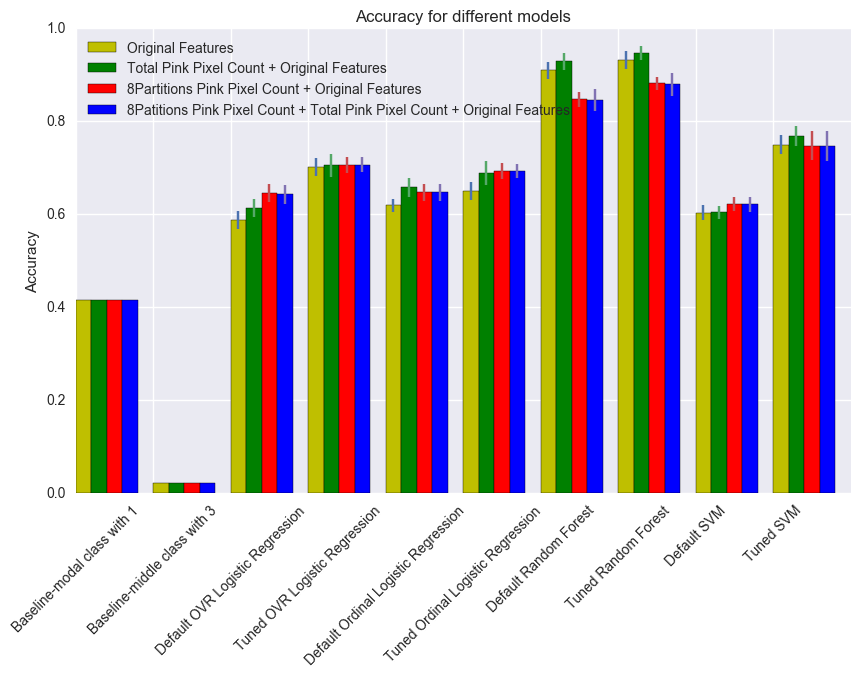

In [95]:
plotBarPlotAllErrAC(ACname_norm, ACori_val_norm, ACpink_val_norm, ACmore_val_norm, ACall_val_norm, ACori_std_norm, ACpink_std_norm, ACmore_std_norm, ACall_std_norm)

In [ ]:
#####CONFUSION MATRIX####

In [99]:
from sklearn.metrics import confusion_matrix
import itertools

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
seed=1
splitSeed = 1

In [102]:
X_train_pink_norm, X_test_pink_norm, y_train, y_test, trainSet_pink_norm, testSet_pink_norm=splitData(dataFrame_pink_norm,"score", splitSeed)

evaluation starting


In [103]:
parameters = {'n_estimators':[10,50,100], 'min_samples_split':[2,5],'max_depth':[None,50,100],'min_samples_leaf':[1,5]}

In [104]:
rf_conf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=seed)
rf_conf_grid = GridSearchCV(rf_conf, parameters, n_jobs=-1, scoring = "neg_mean_squared_error")

In [105]:
rf_conf_grid.fit(X_train_pink_norm, y_train)
y_pred = rf_conf_grid.predict(X_test_pink_norm)

In [116]:
y_pred==y_test

128     True
246     True
56      True
65      True
311     True
192     True
100     True
220     True
347     True
200     True
432     True
266     True
136     True
424     True
131     True
292    False
338     True
177     True
187    False
209     True
16      True
180     True
51      True
164     True
109     True
21      True
134    False
151     True
99      True
50      True
       ...  
461     True
114     True
414     True
331     True
98      True
248     True
335     True
441     True
216     True
181     True
371     True
87      True
221     True
301     True
4       True
90      True
232     True
413     True
333     True
197     True
315     True
110     True
389     True
176     True
459     True
126     True
332     True
405     True
117     True
355     True
Name: score, dtype: bool

In [117]:
svm_parameters = {'C':[0.01,0.1,1,10,100,100,1000]}
svm_model = sklearn.svm.SVC(random_state=seed)
svm_model_grid = GridSearchCV(svm_model, svm_parameters, n_jobs=-1, scoring = "neg_mean_squared_error")
svm_model_grid.fit(X_train_pink_norm, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [118]:
y_pred = rf_conf_grid.predict(X_test_pink_norm)

In [123]:
y_test==y_pred

128     True
246     True
56      True
65      True
311     True
192     True
100     True
220     True
347     True
200     True
432     True
266     True
136     True
424     True
131     True
292    False
338     True
177     True
187    False
209     True
16      True
180     True
51      True
164     True
109     True
21      True
134    False
151     True
99      True
50      True
       ...  
461     True
114     True
414     True
331     True
98      True
248     True
335     True
441     True
216     True
181     True
371     True
87      True
221     True
301     True
4       True
90      True
232     True
413     True
333     True
197     True
315     True
110     True
389     True
176     True
459     True
126     True
332     True
405     True
117     True
355     True
Name: score, dtype: bool

Confusion matrix, without normalization
[[26  4  0  0  0  0]
 [ 0 39  0  0  0  0]
 [ 0  2 11  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  0  4]]


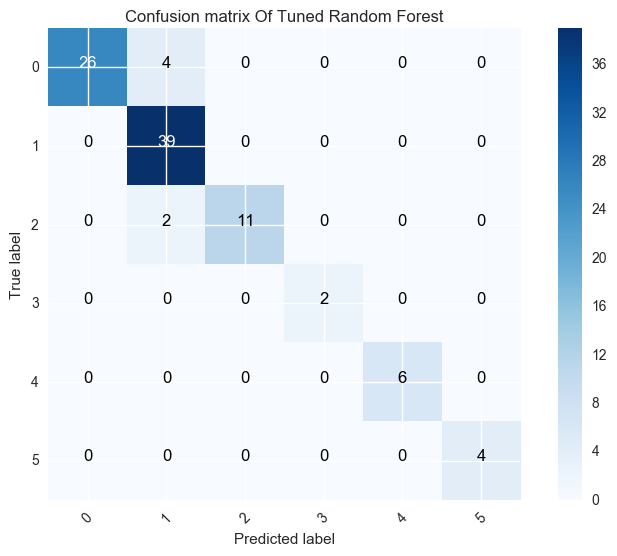

In [69]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5],
                      title='Confusion matrix Of Tuned Random Forest')

In [70]:
#####LEARNING CURVE####

In [71]:
from sklearn.model_selection import learning_curve

In [72]:
seed=1

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Negative Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = "neg_mean_squared_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

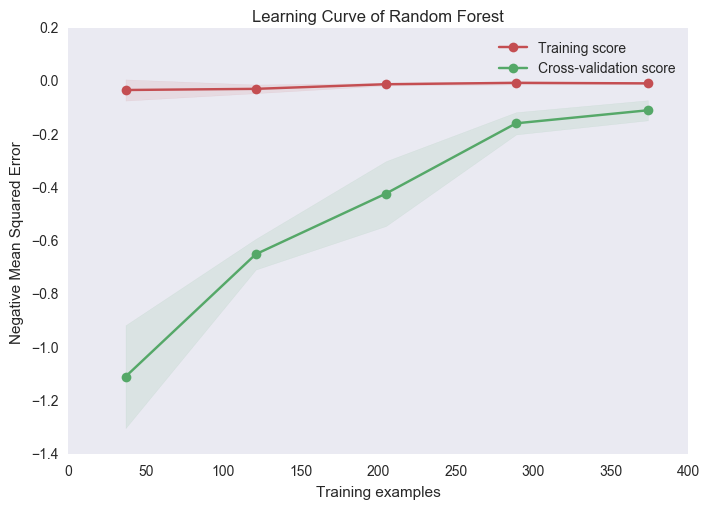

In [74]:
X = dataFrame_pink_norm.drop("score",1)
y = dataFrame_pink_norm["score"]
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed)
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
plot_learning_curve(rf_model, "Learning Curve of Random Forest", X, y, ylim=None, cv=sss, n_jobs=-1)

In [ ]:
#####RUN DISTRIBUTION###

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [34]:
dataFrame_ori = pd.read_csv("original.csv")
dataFrame_pink = pd.read_csv("pink.csv")
dataFrame_more = pd.read_csv("more.csv")
dataFrame_all = pd.read_csv("all.csv")

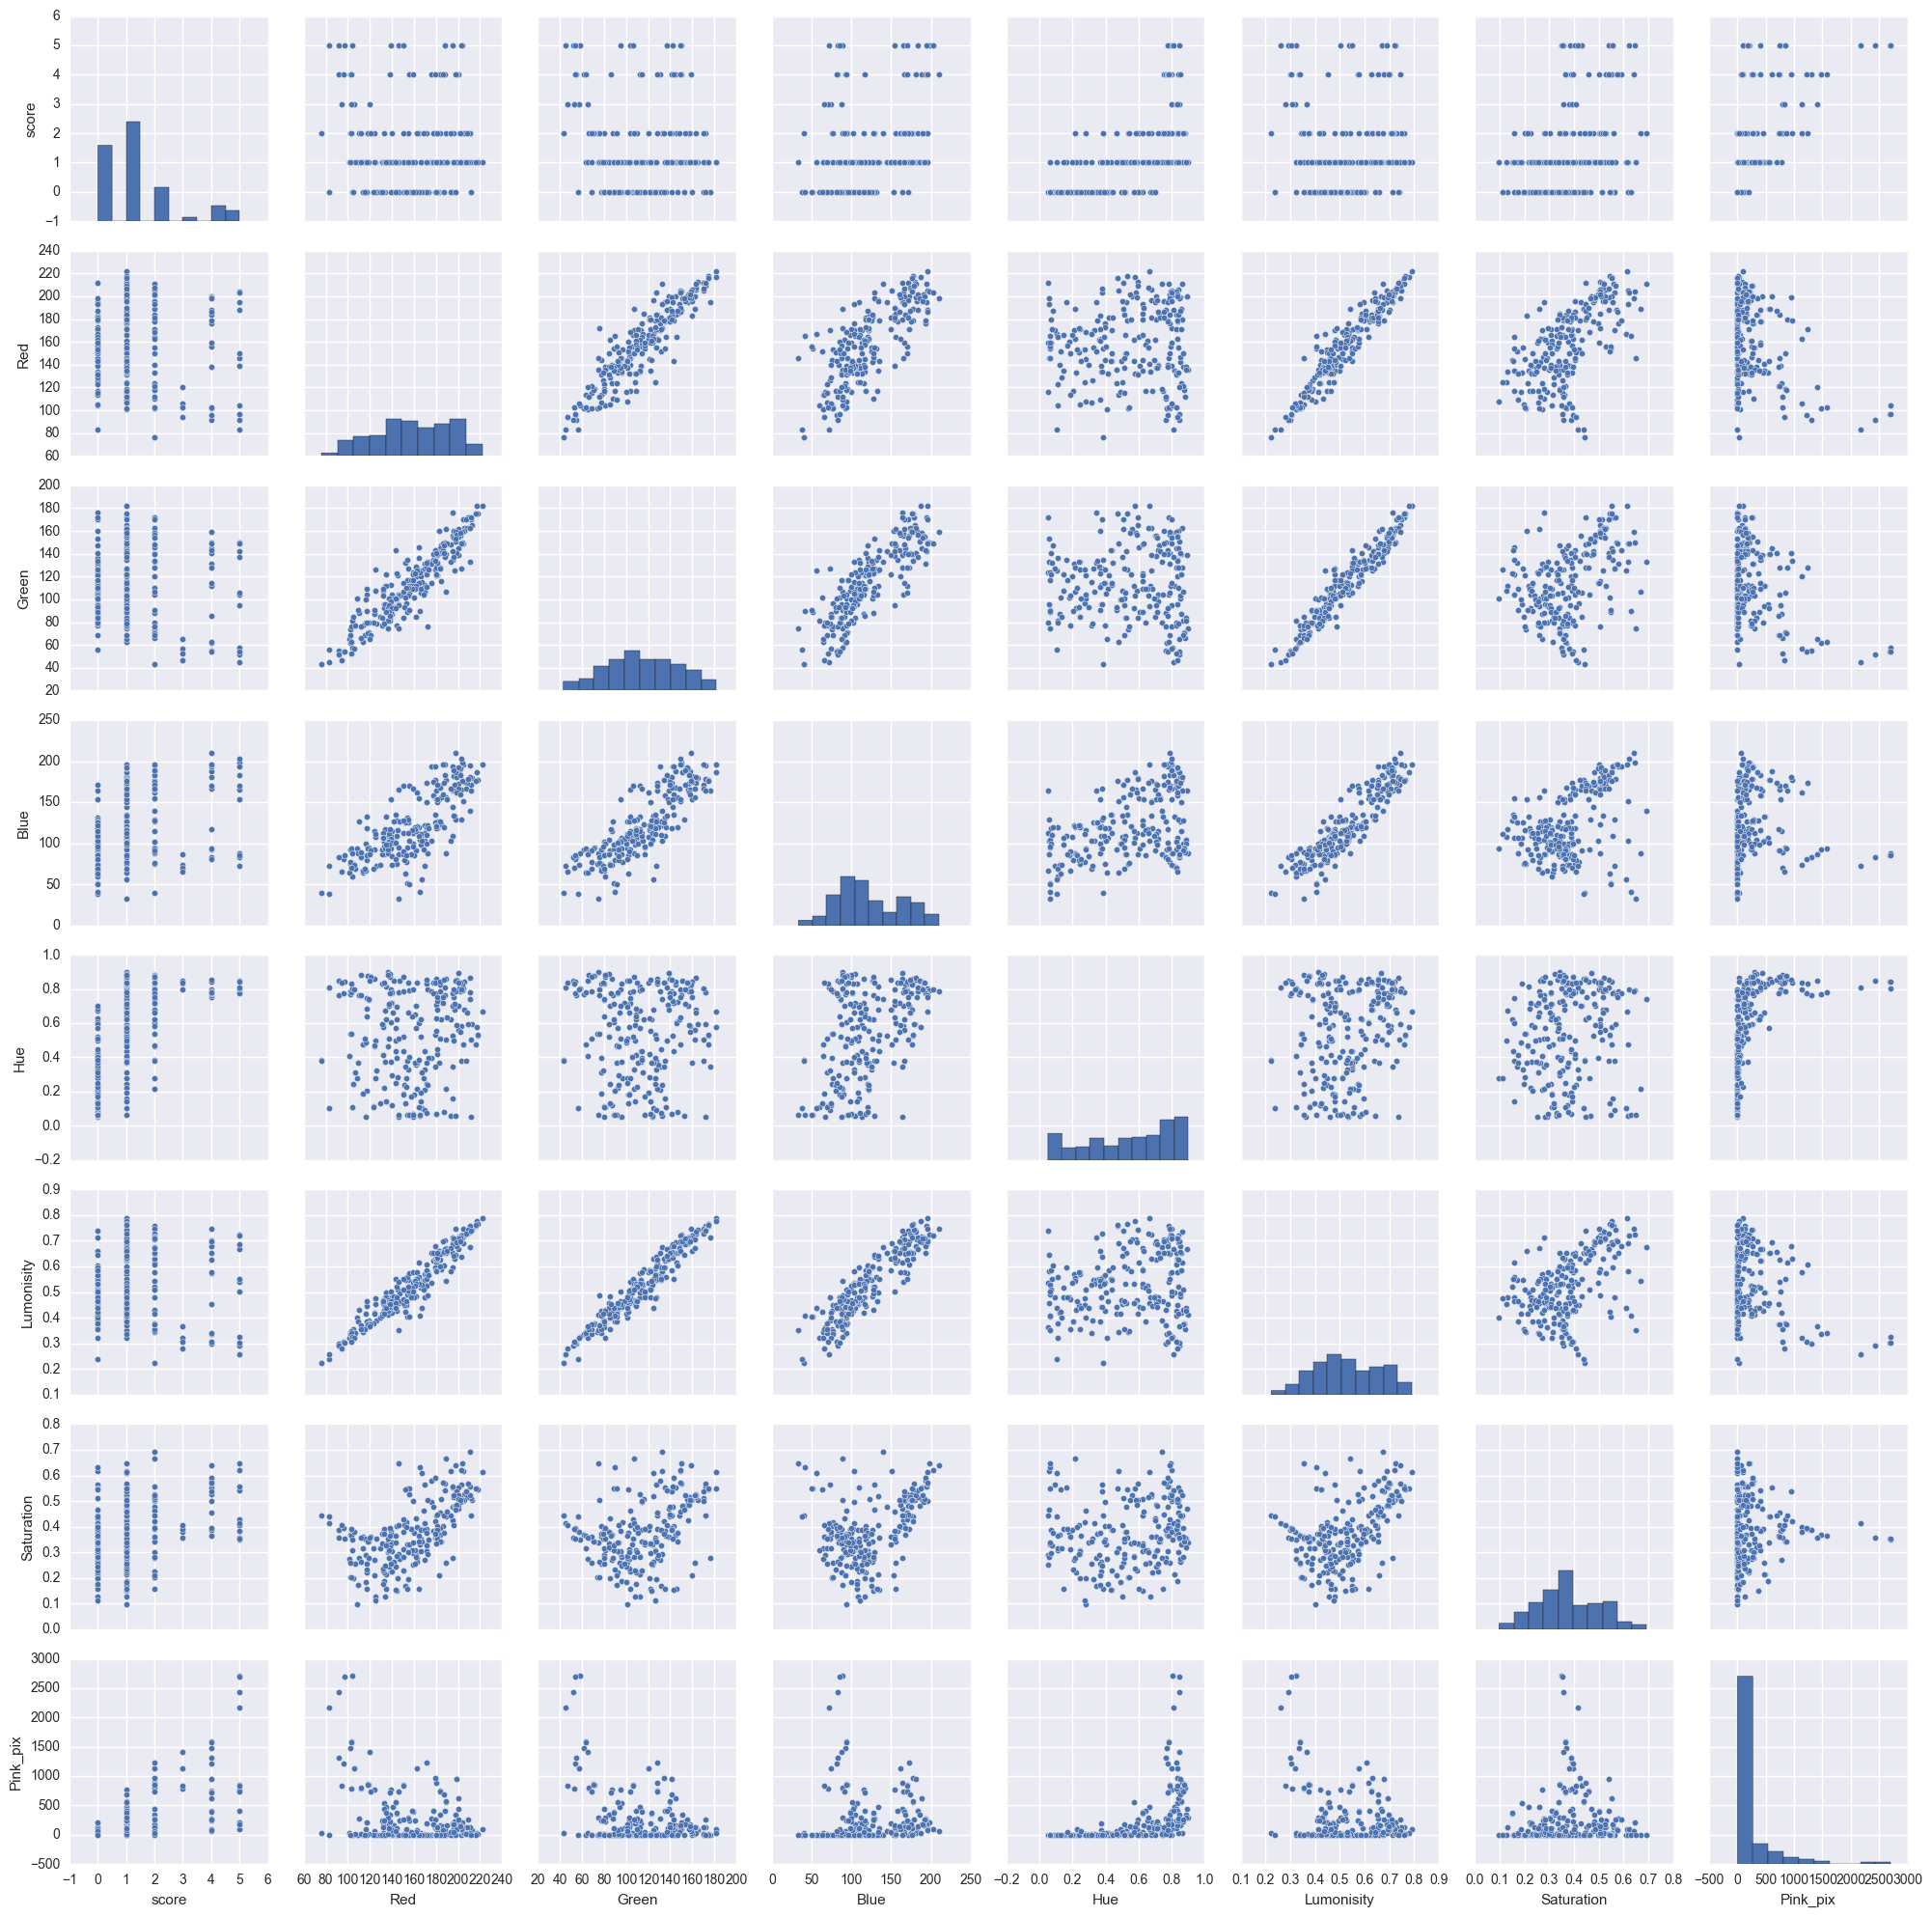

In [60]:
sns.pairplot(dataFrame_pink)

In [75]:
#########PLOT SINGLE DISTRIBUTION#######

In [77]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d075bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d41cd90>]], dtype=object)

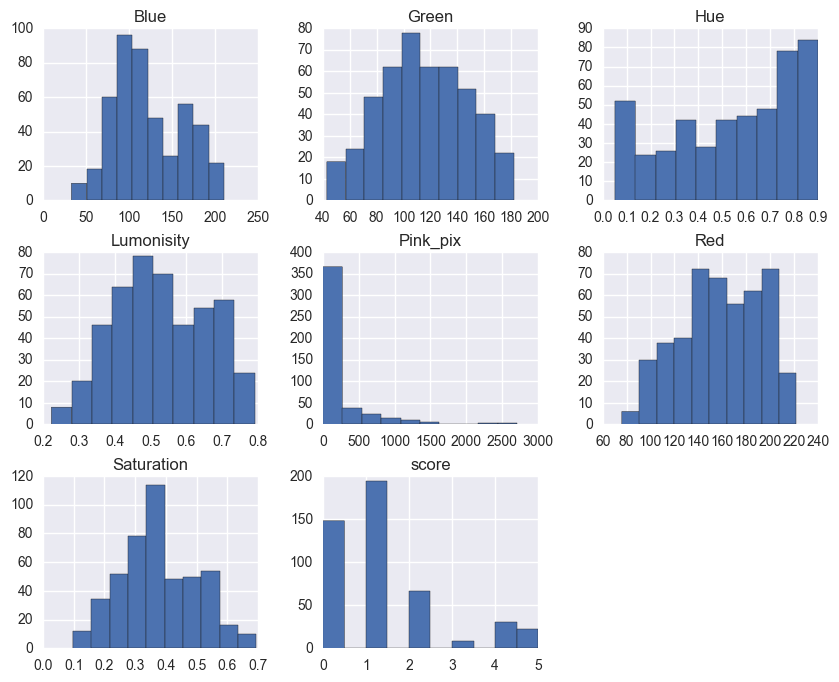

In [83]:
dataFrame_pink.hist(figsize=(10,8))

In [ ]:
#####VALIDATION CURVE########

In [86]:
from sklearn.model_selection import validation_curve

In [ ]:
seed=1

In [93]:
param_range = [1,5,10,20,30,50,100,150,200,500,1000]
rf_model_val = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=seed, min_samples_split=2, max_features='auto', max_depth=None, min_samples_leaf=1)
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
train_scores, test_scores = validation_curve(
    rf_model_val, X, y, param_name="n_estimators", param_range=param_range,
    cv=sss, scoring='neg_mean_squared_error', n_jobs=-1)

In [94]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

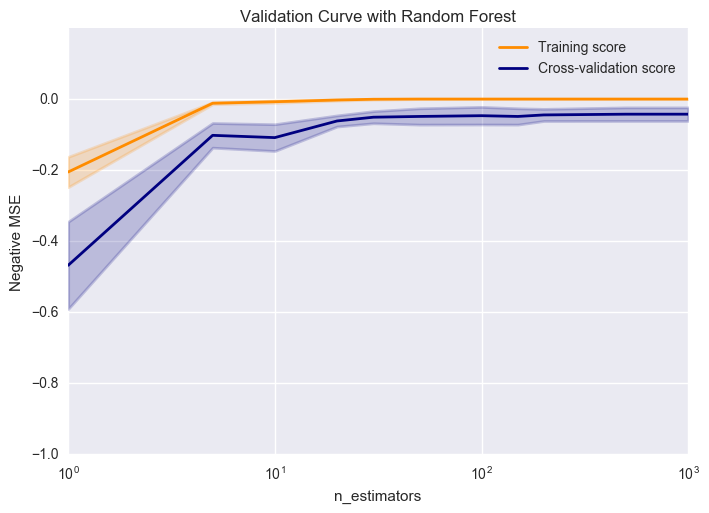

In [95]:

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Negative MSE")
plt.ylim(-1.0, 0.2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [96]:
#######FEATURE IMPORTANCE####

In [98]:
feat_pink_val = np.mean(np.asarray(feat_pink_norm),axis=0)

In [103]:
def plotFeatureImp(names, values1):
    fig, ax = plt.subplots()
    width=0.35
    ax.bar(np.arange(len(names)), values1, width, color='r', label='Original')
    #ax.bar(np.arange(len(names))+width, values2, width, color='b', label='Added Feature')
    
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=45)
    
    plt.title('Feature Importance from Original Dataframe and Dataframe with Added Feature')
    ax.set_ylabel('Normalized Gini Importance')
    plt.legend(loc=1)

In [118]:
dataFrame_pink_norm.drop('score',1).columns.values

array(['Red', 'Green', 'Blue', 'Hue', 'Lumonisity', 'Saturation',
       'Pink_pix'], dtype=object)

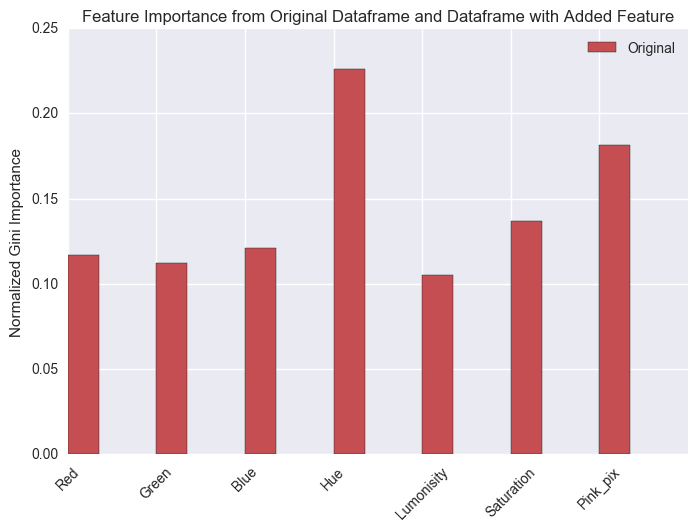

In [116]:
plotFeatureImp(X.columns.values,feat_pink_val)

In [3]:
#####RUN OLD RESULTS###

In [124]:
width = 200
height = 100
data = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type
        pixelArr = flattenImage(imgToMatrix('final/'+fn))
        data.append(pixelArr)

In [129]:
import pandas as pd
binPixelArr = np.array(data)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)

In [130]:
X['score'] = dataFrame_all_norm['score']

In [131]:
df=X

In [133]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from PIL import Image
import operator
import os
from sklearn.linear_model import LogisticRegression
import colorsys
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import sklearn.ensemble
from sklearn import metrics
import sklearn
 
 
def getMSE(model, X, y):
    return metrics.mean_squared_error(model.predict(X),y)
 
def splitData(df,label, seed):
    print("evaluation starting")
    df_X = df.drop(label,1)
    df_y = df[label]
    sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    X_train = np.array(0)
    X_test = np.array(0)
    y_train = np.array(0)
    y_test = np.array(0)
    for train_index, test_index in sss.split(df_X,df_y):
        X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
        trainSet, testSet = df.iloc[train_index], df.iloc[test_index]
    return X_train, X_test, y_train, y_test, trainSet, testSet
 
 
 
###assuming your dataframe is called df
 
dataFrame_ori_norm = df
 
dataFrame_ori_target = dataFrame_ori_norm[['score']]
dataFrame_ori_norm = dataFrame_ori_norm.drop('score',1)
dataFrame_ori_norm=dataFrame_ori_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_ori_norm['score'] = dataFrame_ori_target
 
 
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=1, n_estimators=50)
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)
 
rf_model.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getACC(rf_model, X_test_ori_norm, y_test))

evaluation starting
0.712765957447


In [ ]:
###VALUE ABOVE IS 60000RGB######

In [134]:
width = 200
height = 100
data = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type
        pixelArr = flattenImage(imgToMatrix('final/'+fn,True))
        data.append(pixelArr)

In [135]:
import pandas as pd
binPixelArr = np.array(data)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)

In [136]:
X['score'] = dataFrame_all_norm['score']

In [137]:
df = X

In [138]:
dataFrame_ori_norm = df
 
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=1, n_estimators=50)
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)
 
rf_model.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getACC(rf_model, X_test_ori_norm, y_test))

evaluation starting
0.595744680851


In [ ]:
####THE RESULT ABOVE IS GRAYSCALED VALUES########

In [141]:
dataFrame_ori_norm = dataFrame_ori
 
dataFrame_ori_target = dataFrame_ori_norm[['score']]
dataFrame_ori_norm = dataFrame_ori_norm.drop('score',1)
dataFrame_ori_norm=dataFrame_ori_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_ori_norm['score'] = dataFrame_ori_target
 
 
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=1, n_estimators=50)
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)
 
rf_model.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getACC(rf_model, X_test_ori_norm, y_test))

evaluation starting
0.86170212766


In [142]:
####THE RESULT ABOVE IS AVERAGE VALUES##########

In [143]:
dataBlur = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type        
        img = cv2.imread('final/'+fn)
        blur = cv2.blur(img,(5,5))
        pixelArrBlur = blur.ravel()
        dataBlur.append(pixelArrBlur)

In [144]:
binPixelArr = np.array(dataBlur)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)

In [145]:
X['score'] = dataFrame_ori['score']

In [146]:
df = X

In [147]:
dataFrame_ori_norm = df
 
dataFrame_ori_target = dataFrame_ori_norm[['score']]
dataFrame_ori_norm = dataFrame_ori_norm.drop('score',1)
dataFrame_ori_norm=dataFrame_ori_norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataFrame_ori_norm['score'] = dataFrame_ori_target
 
 
rf_model = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,random_state=1, n_estimators=50)
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)
 
rf_model.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getACC(rf_model, X_test_ori_norm, y_test))

evaluation starting
0.744680851064


In [149]:
########LR for the above########

In [150]:
width = 200
height = 100
data = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type
        pixelArr = flattenImage(imgToMatrix('final/'+fn))
        data.append(pixelArr)
import pandas as pd
binPixelArr = np.array(data)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)


In [151]:
X['score'] = dataFrame_all_norm['score']

In [152]:
df=X

In [156]:
dataFrame_ori_norm = df
param = {'C':[0.1,10,1000]}
 
lr = LogisticRegression()
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)

lr_grid_search = GridSearchCV(lr, param, cv = 5, scoring = 'log_loss')
lr_grid_search.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getMSE(lr_grid_search, X_test_ori_norm, y_test))

evaluation starting
0.734042553191


In [157]:
lr_grid_search.best_params_

{'C': 0.1}

In [ ]:
#####ABOVE IS LR MSE of 6000RGB####

In [158]:
width = 200
height = 100
data = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type
        pixelArr = flattenImage(imgToMatrix('final/'+fn,True))
        data.append(pixelArr)

import pandas as pd
binPixelArr = np.array(data)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)

X['score'] = dataFrame_all_norm['score']

In [159]:
df = X

In [160]:
dataFrame_ori_norm = df
param = {'C':[0.1,10,1000]}
 
lr = LogisticRegression()
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)

lr_grid_search = GridSearchCV(lr, param, cv = 5, scoring = 'log_loss')
lr_grid_search.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getMSE(lr_grid_search, X_test_ori_norm, y_test))

evaluation starting
1.42553191489


In [161]:
lr_grid_search.best_params_

{'C': 0.1}

In [ ]:
###### ABOVE IS GRAY SCALED#####

In [162]:
ori_val_norm

array([ 1.79787234,  4.90425532,  1.69255319,  0.39468085,  0.90319149,
        0.5       ,  0.16702128,  0.11914894,  1.65744681,  0.27340426])

In [163]:
dataBlur = []
for fn in os.listdir('final'):
    if (fn[-4:] == ".jpg"): #ignoring DS_Store & ensuring correct file type        
        img = cv2.imread('final/'+fn)
        blur = cv2.blur(img,(5,5))
        pixelArrBlur = blur.ravel()
        dataBlur.append(pixelArrBlur)

binPixelArr = np.array(dataBlur)
index = [i for i in range(1, len(binPixelArr)+1)]
X = pd.DataFrame(binPixelArr)

X['score'] = dataFrame_ori['score']



In [164]:
df=X

In [165]:
dataFrame_ori_norm = df
param = {'C':[0.1,10,1000]}
 
lr = LogisticRegression()
 
X_train_ori_norm, X_test_ori_norm, y_train, y_test, trainSet_ori_norm, testSet_ori_norm=splitData(dataFrame_ori_norm,"score", 1)

lr_grid_search = GridSearchCV(lr, param, cv = 5, scoring = 'log_loss')
lr_grid_search.fit(X_train_ori_norm, y_train)
 
####result is printed here
print(getMSE(lr_grid_search, X_test_ori_norm, y_test))

evaluation starting
0.63829787234
